In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

max_tx_dist = 50.0

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
nodes = ["N0", "N2", "N3", "N13", "N14", "N16", "N18", "N24", "N29"]
methods = ["L", "P"]

position_log_path = "./vehicle_position_log.csv"
if not os.path.exists(position_log_path):
    print(f"Missing vehicle position log: {position_log_path}")
    exit(1)
df_pos_all = pd.read_csv(position_log_path)
time_list = sorted(df_pos_all["Time"].unique())

def parse_node_id(node_str):
    if isinstance(node_str, str) and "[" in node_str and "]" in node_str:
        return int(node_str.split("[")[1].split("]")[0])
    else:
        return None

for method in methods:
    print(f"\n=== Method: {method} (Aggregated) ===")
    totals, invalids, node_labels = [], [], []

    node_stats = {int(node[1:]): {"total": 0, "invalid": 0} for node in nodes}

    for target_time in time_list:
        df_pos = df_pos_all[df_pos_all["Time"] == target_time]
        if df_pos.empty:
            continue

        for node_folder in nodes:
            node_num = int(node_folder[1:])
            route_log_path = os.path.join(base_path, method, density, speed, node_folder, "routing_table_log.csv")
            
            if not os.path.exists(route_log_path):
                continue

            df_route = pd.read_csv(route_log_path)
            df_route = df_route[df_route["Time"] == target_time]
            if df_route.empty:
                continue

            for _, row in df_route.iterrows():
                next_id = parse_node_id(row["NextHop"])
                if next_id is None:
                    continue
                node_pos = df_pos[df_pos["Node"] == node_num]
                next_pos = df_pos[df_pos["Node"] == next_id]
                if node_pos.empty or next_pos.empty:
                    continue

                node_x, node_y = node_pos.iloc[0][["X", "Y"]]
                next_x, next_y = next_pos.iloc[0][["X", "Y"]]
                dist = sqrt((node_x - next_x)**2 + (node_y - next_y)**2)

                node_stats[node_num]["total"] += 1
                if dist > max_tx_dist:
                    node_stats[node_num]["invalid"] += 1

    for node_num in sorted(node_stats.keys()):
        t, inv = node_stats[node_num]["total"], node_stats[node_num]["invalid"]
        print(f"Node {node_num}: Total={t}, Invalid={inv}")
        totals.append(t)
        invalids.append(inv)
        node_labels.append(f"N{node_num}")

    if not totals:
        continue

    x = np.arange(len(node_labels))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width/2, totals, width, label='Total')
    ax.bar(x + width/2, invalids, width, label='Invalid')

    ax.set_xlabel('Node')
    ax.set_ylabel('Count (aggregated)')
    ax.set_title(f'Aggregated Routing Entries (Method: {method})')
    ax.set_xticks(x)
    ax.set_xticklabels(node_labels)
    ax.legend()

    plt.tight_layout()
    plt.show()



=== Method: L (Aggregated) ===


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
node = "N2"
methods = ["L", "P"]
max_tx_dist = 500.0

for method in methods:
    pos_path = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(pos_path):
        print(f"[{method}] 위치 파일 없음: {pos_path}")
        continue

    df_all = pd.read_csv(pos_path)
    print(f"\n=== Method: {method} | Node: {node} | File: position.csv ===")
    print(f"     조건: Density={density}, Speed={speed}, MaxTx={max_tx_dist}m")

    times = sorted(df_all["Time"].unique())
    avg_distances, invalid_ratios, times_for_plot = [], [], []

    for t in times:
        df_t = df_all[df_all["Time"] == t]
        if df_t.empty:
            avg_distances.append(0)
            invalid_ratios.append(0)
            times_for_plot.append(t)
            continue

        dists = []
        invalid, total = 0, 0

        for _, row in df_t.iterrows():
            dist = sqrt((row["NodeX"] - row["NextHopX"])**2 + (row["NodeY"] - row["NextHopY"])**2)
            dists.append(dist)
            total += 1
            if dist > max_tx_dist:
                invalid += 1

        avg = sum(dists) / len(dists) if dists else 0
        ratio = (invalid / total) * 100.0 if total > 0 else 0.0

        avg_distances.append(avg)
        invalid_ratios.append(ratio)
        times_for_plot.append(t)

        print(f"[{method}] Time={t:>3} | AvgDist={avg:.2f}m | Invalid={invalid}/{total} ({ratio:.2f}%)")

    plt.figure(figsize=(10, 4))
    plt.plot(times_for_plot, avg_distances, label="Avg Distance", color='blue')
    plt.xlabel("Time (s)")
    plt.ylabel("Average Distance (m)")
    plt.title(f"{method} - {node} - Avg Distance to NextHop")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(times_for_plot, invalid_ratios, label="Invalid Ratio", color='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Invalid Ratio (%)")
    plt.title(f"{method} - {node} - Invalid NextHop Ratio (> {max_tx_dist}m)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


[L] 위치 파일 없음: C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07\L\D400\S30\N2\position.csv
[P] 위치 파일 없음: C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07\P\D400\S30\N2\position.csv


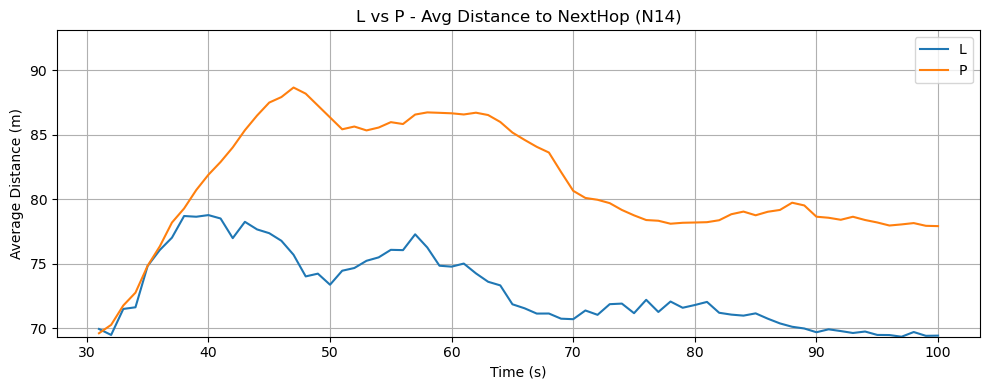

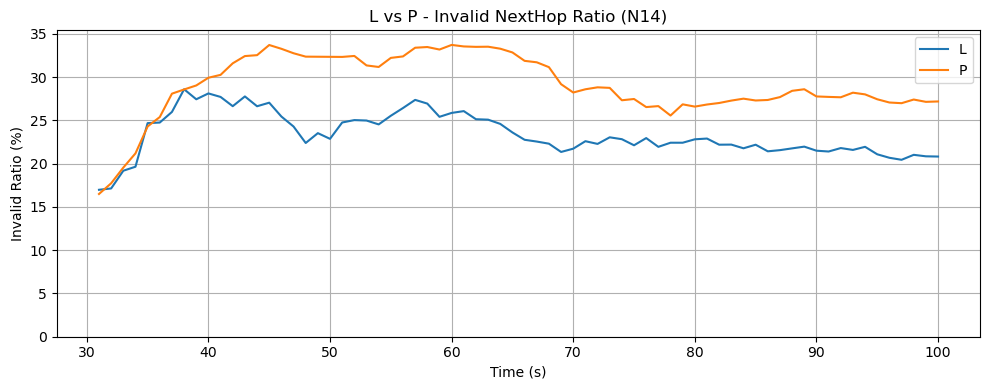

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 100.0

results = {}

for method in methods:
    pos_path = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(pos_path):
        print(f"[{method}] 위치 파일 없음: {pos_path}")
        continue

    df_all = pd.read_csv(pos_path)
    times = sorted(df_all["Time"].unique())
    avg_distances, invalid_ratios, times_for_plot = [], [], []

    for t in times:
        df_t = df_all[df_all["Time"] == t]
        if df_t.empty:
            avg_distances.append(0)
            invalid_ratios.append(0)
            times_for_plot.append(t)
            continue

        dists = []
        invalid, total = 0, 0

        for _, row in df_t.iterrows():
            dist = sqrt((row["NodeX"] - row["NextHopX"])**2 + (row["NodeY"] - row["NextHopY"])**2)
            dists.append(dist)
            total += 1
            if dist > max_tx_dist:
                invalid += 1

        avg = sum(dists) / len(dists) if dists else 0
        ratio = (invalid / total) * 100.0 if total > 0 else 0.0

        avg_distances.append(avg)
        invalid_ratios.append(ratio)
        times_for_plot.append(t)

    results[method] = {
        "times": times_for_plot,
        "avg_distances": avg_distances,
        "invalid_ratios": invalid_ratios
    }

all_avg_dists = [v for m in results.values() for v in m["avg_distances"]]
all_invalids = [v for m in results.values() for v in m["invalid_ratios"]]

avg_ymin, avg_ymax = min(all_avg_dists), max(all_avg_dists)
inv_ymin, inv_ymax = 0, max(all_invalids)

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["times"], results[method]["avg_distances"], label=method)
plt.xlabel("Time (s)")
plt.ylabel("Average Distance (m)")
plt.title(f"L vs P - Avg Distance to NextHop ({node})")
plt.ylim(avg_ymin, avg_ymax * 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["times"], results[method]["invalid_ratios"], label=method)
plt.xlabel("Time (s)")
plt.ylabel("Invalid Ratio (%)")
plt.title(f"L vs P - Invalid NextHop Ratio ({node})")
plt.ylim(inv_ymin, inv_ymax * 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
import os
import pandas as pd
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 100.0

results = {}

for method in methods:
    pos_path = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(pos_path):
        print(f"[{method}] 위치 파일 없음: {pos_path}")
        continue

    df_all = pd.read_csv(pos_path)
    times = sorted(df_all["Time"].unique())
    valid_counts = []

    for t in times:
        df_t = df_all[df_all["Time"] == t]
        if df_t.empty:
            valid_counts.append(0)
            continue

        invalid, total = 0, 0
        for _, row in df_t.iterrows():
            dist = sqrt((row["NodeX"] - row["NextHopX"])**2 + (row["NodeY"] - row["NextHopY"])**2)
            total += 1
            if dist > max_tx_dist:
                invalid += 1

        valid = total - invalid
        valid_counts.append(valid)

    results[method] = {
        "times": times,
        "valid_counts": valid_counts
    }

    print(f"[{method}] Valid NextHop Counts:")
    print(valid_counts)


[L] Valid NextHop Counts:
[1981, 4035, 4552, 4489, 4701, 4824, 4855, 5051, 5135, 5195, 5254, 5055, 5140, 5203, 5349, 5244, 5469, 5629, 5636, 5757, 5768, 5818, 2807, 6861, 6917, 6841, 6864, 6861, 6784, 6762, 6814, 6750, 6776, 6773, 6760, 6802, 6890, 6958, 6922, 6941, 6953, 7007, 7042, 7057, 7063, 7057, 7080]
[P] Valid NextHop Counts:
[2107, 3588, 4127, 4168, 4255, 4340, 4485, 4722, 4807, 5144, 5206, 5235, 5315, 5383, 5426, 5598, 5748, 5856, 2816, 5993, 6079, 6097, 6063, 6039, 5988, 5972, 5986, 5931, 5950, 5951, 5994, 5968, 5955, 6084, 6058, 6109, 6307, 6466, 6433, 6496, 6568, 6660, 6767, 6807, 6848, 6902, 6894, 6885, 6893, 6913, 6886, 6912, 6919, 6933, 6886, 6840, 6874, 6933, 7004, 6964, 6979, 6988, 7013, 7047, 7059, 7061, 7052, 7079]


In [8]:
import os
import pandas as pd
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 100.0

df_dict = {}
time_dict = {}
valid_counts_dict = {}

for method in methods:
    pos_path = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(pos_path):
        print(f"[{method}] 위치 파일 없음: {pos_path}")
        continue

    df_all = pd.read_csv(pos_path)
    df_dict[method] = df_all
    times = sorted(df_all["Time"].unique())
    time_dict[method] = times

    valid_counts = []
    for t in times:
        df_t = df_all[df_all["Time"] == t]
        if df_t.empty:
            valid_counts.append(0)
            continue

        invalid, total = 0, 0
        for _, row in df_t.iterrows():
            dist = sqrt((row["NodeX"] - row["NextHopX"])**2 + (row["NodeY"] - row["NextHopY"])**2)
            total += 1
            if dist > max_tx_dist:
                invalid += 1
        valid_counts.append(total - invalid)

    valid_counts_dict[method] = valid_counts

for method in methods:
    print(f"\n[{method}] Time List ({len(time_dict[method])}):")
    print(time_dict[method])
    print(f"[{method}] Valid NextHop Counts ({len(valid_counts_dict[method])}):")
    print(valid_counts_dict[method])

common_times = sorted(set(time_dict["L"]) & set(time_dict["P"]))
print(f"\n[공통 Time] ({len(common_times)}개):")
print(common_times)

for method in methods:
    df_all = df_dict[method]
    valid_common = []
    for t in common_times:
        df_t = df_all[df_all["Time"] == t]
        if df_t.empty:
            valid_common.append(0)
            continue

        invalid, total = 0, 0
        for _, row in df_t.iterrows():
            dist = sqrt((row["NodeX"] - row["NextHopX"])**2 + (row["NodeY"] - row["NextHopY"])**2)
            total += 1
            if dist > max_tx_dist:
                invalid += 1
        valid_common.append(total - invalid)

    print(f"\n[{method}] Valid NextHop Counts (공통 시간 기준):")
    print(valid_common)



[L] Time List (70):
[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[L] Valid NextHop Counts (70):
[1981, 4035, 4552, 4489, 4701, 4824, 4855, 5051, 5135, 5195, 5254, 5055, 5140, 5203, 5349, 5244, 5469, 5629, 5636, 5757, 5768, 5818, 5939, 5988, 5978, 5927, 5907, 5817, 5867, 5856, 5878, 5915, 5982, 6187, 6090, 6312, 6455, 6491, 6688, 6677, 6844, 6944, 6929, 6917, 7015, 7031, 6861, 6917, 6841, 6864, 6861, 6784, 6762, 6814, 6750, 6776, 6773, 6760, 6802, 6890, 6958, 6922, 6941, 6953, 7007, 7042, 7057, 7063, 7057, 7080]

[P] Time List (68):
[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,

In [12]:
import os
import pandas as pd

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
method = "L"
density = "D400"
speed = "S30"
node = "N14"

rt_path = os.path.join(base_path, method, density, speed, node, "routing_table_log.csv")

df_rt = pd.read_csv(rt_path)

df_node14 = df_rt[df_rt["Node"] == "node[14]"]

df_range = df_node14[df_node14["Time"].between(53, 75)]

print(f"[node[14] - L 방식] Time 53~75 라우팅 테이블 엔트리 수: {len(df_range)}")
print(df_range)


[node[14] - L 방식] Time 53~75 라우팅 테이블 엔트리 수: 894
        Time      Node Destination    NextHop  Metric   Lifetime  DestSeq  \
147461    53  node[14]      rsu[0]  node[263]       6  55.901244       14   
147462    53  node[14]     node[2]    node[2]       1  54.667562        0   
147463    53  node[14]     node[6]    node[6]       1  54.998859        0   
147464    53  node[14]    node[18]   node[18]       1  53.573833        0   
147465    53  node[14]    node[20]   node[20]       1  54.416950        0   
...      ...       ...         ...        ...     ...        ...      ...   
329765    75  node[14]   node[382]  node[382]       1  77.107092       18   
329766    75  node[14]   node[395]  node[395]       1  77.427649       19   
329767    75  node[14]   node[401]  node[401]       1  79.726467        0   
329768    75  node[14]   node[404]  node[404]       1  77.901101       23   
329769    75  node[14]   node[418]  node[418]       1  78.606113        1   

        Active  
147461    

In [16]:
df_filtered = df_send[(df_send["Time"] >= 53) & (df_send["Time"] <= 75)]
print(df_filtered["PacketType"].value_counts())


PacketType
HELLO               4625
inet::aodv::Rreq    2095
inet::aodv::Rrep      96
inet::aodv::Rerr      24
Name: count, dtype: int64


In [10]:
for method in ["L", "P"]:
    df = pd.read_csv(os.path.join(base_path, method, density, speed, node, "position.csv"))
    counts = df.groupby("Time").size()
    print(f"\n[{method}] Time별 위치 기록 수:")
    print(counts)



[L] Time별 위치 기록 수:
Time
31     2386
32     4869
33     5632
34     5586
35     6241
36     6410
37     6558
38     7073
39     7076
40     7226
41     7267
42     6890
43     7115
44     7091
45     7331
46     7033
47     7223
48     7252
49     7369
50     7463
51     7665
52     7760
76     3681
77     8789
78     8915
79     8817
80     8892
81     8898
82     8718
83     8691
84     8710
85     8674
86     8623
87     8634
88     8640
89     8716
90     8776
91     8852
92     8851
93     8851
94     8907
95     8878
96     8877
97     8870
98     8942
99     8915
100    8941
dtype: int64

[P] Time별 위치 기록 수:
Time
31     2523
32     4361
33     5129
34     5288
35     5620
       ... 
96     9661
97     9667
98     9726
99     9678
100    9721
Length: 68, dtype: int64


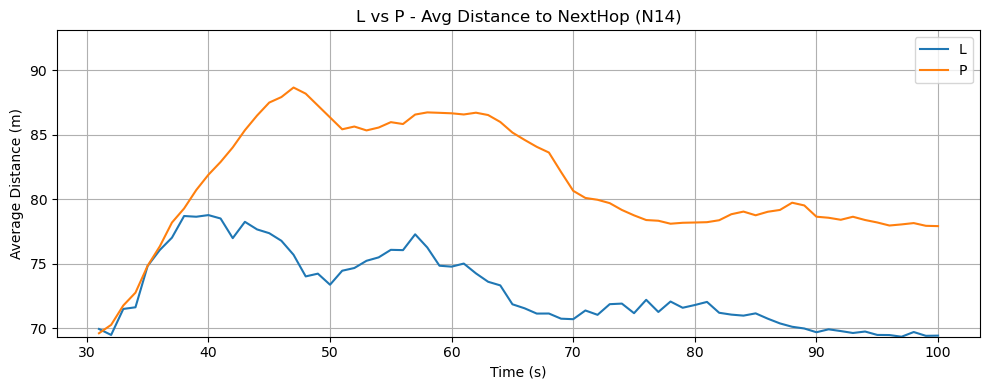

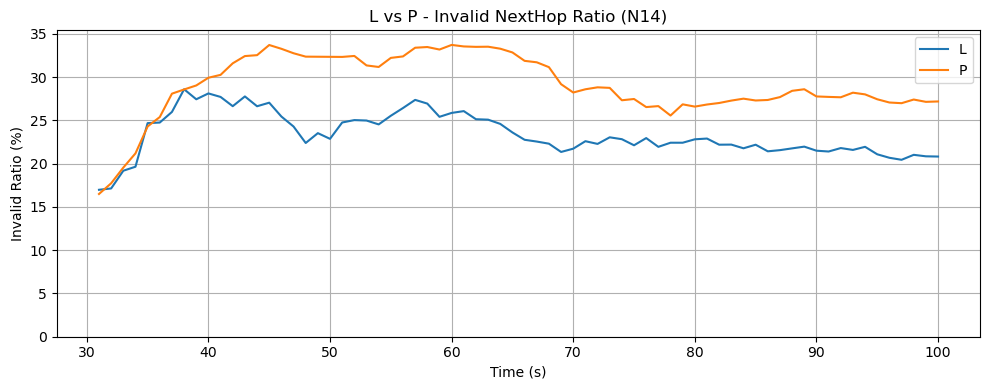

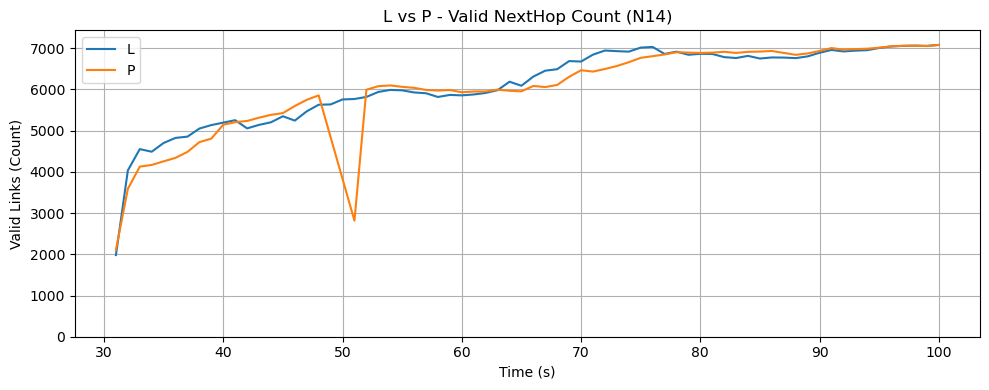

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 100.0

results = {}

for method in methods:
    pos_path = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(pos_path):
        print(f"[{method}] 위치 파일 없음: {pos_path}")
        continue

    df_all = pd.read_csv(pos_path)
    times = sorted(df_all["Time"].unique())
    avg_distances, invalid_ratios, valid_counts, times_for_plot = [], [], [], []

    for t in times:
        df_t = df_all[df_all["Time"] == t]
        if df_t.empty:
            avg_distances.append(0)
            invalid_ratios.append(0)
            valid_counts.append(0)
            times_for_plot.append(t)
            continue

        dists = []
        invalid, total = 0, 0

        for _, row in df_t.iterrows():
            dist = sqrt((row["NodeX"] - row["NextHopX"])**2 + (row["NodeY"] - row["NextHopY"])**2)
            dists.append(dist)
            total += 1
            if dist > max_tx_dist:
                invalid += 1

        avg = sum(dists) / len(dists) if dists else 0
        ratio = (invalid / total) * 100.0 if total > 0 else 0.0

        avg_distances.append(avg)
        invalid_ratios.append(ratio)
        valid_counts.append(total - invalid)
        times_for_plot.append(t)

    results[method] = {
        "times": times_for_plot,
        "avg_distances": avg_distances,
        "invalid_ratios": invalid_ratios,
        "valid_counts": valid_counts
    }

all_avg_dists = [v for m in results.values() for v in m["avg_distances"]]
all_invalids = [v for m in results.values() for v in m["invalid_ratios"]]
all_valid_counts = [v for m in results.values() for v in m["valid_counts"]]

avg_ymin, avg_ymax = min(all_avg_dists), max(all_avg_dists)
inv_ymin, inv_ymax = 0, max(all_invalids)
val_ymin, val_ymax = 0, max(all_valid_counts)

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["times"], results[method]["avg_distances"], label=method)
plt.xlabel("Time (s)")
plt.ylabel("Average Distance (m)")
plt.title(f"L vs P - Avg Distance to NextHop ({node})")
plt.ylim(avg_ymin, avg_ymax * 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["times"], results[method]["invalid_ratios"], label=method)
plt.xlabel("Time (s)")
plt.ylabel("Invalid Ratio (%)")
plt.title(f"L vs P - Invalid NextHop Ratio ({node})")
plt.ylim(inv_ymin, inv_ymax * 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["times"], results[method]["valid_counts"], label=method)
plt.xlabel("Time (s)")
plt.ylabel("Valid Links (Count)")
plt.title(f"L vs P - Valid NextHop Count ({node})")
plt.ylim(val_ymin, val_ymax * 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[INFO] 분석 시작: L


L 경로 추적:   0%|          | 0/560073 [00:00<?, ?it/s]C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  n_pos = df_pos.loc[(t, node_id)]
C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  nh_pos = df_pos.loc[(t, nexthop_id)]
L 경로 추적: 100%|██████████| 560073/560073 [02:44<00:00, 3397.65it/s] 


[INFO] 분석 시작: P


P 경로 추적:   0%|          | 0/606140 [00:00<?, ?it/s]C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  n_pos = df_pos.loc[(t, node_id)]
C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  nh_pos = df_pos.loc[(t, nexthop_id)]
P 경로 추적: 100%|██████████| 606140/606140 [07:05<00:00, 1425.40it/s]



[L 방식]
 - 평균 거리: 80.50 m
 - 유효 링크 수: 236947개
 - 무효 링크 수: 109115개
 - 무효 비율: 31.53%


[P 방식]
 - 평균 거리: 115.16 m
 - 유효 링크 수: 482126개
 - 무효 링크 수: 575880개
 - 무효 비율: 54.43%



C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:99: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:99: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:99: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  plt.tight_layout()
C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:99: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  plt.tight_layout()
C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:99: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_11876\3122099608.py:99: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE 

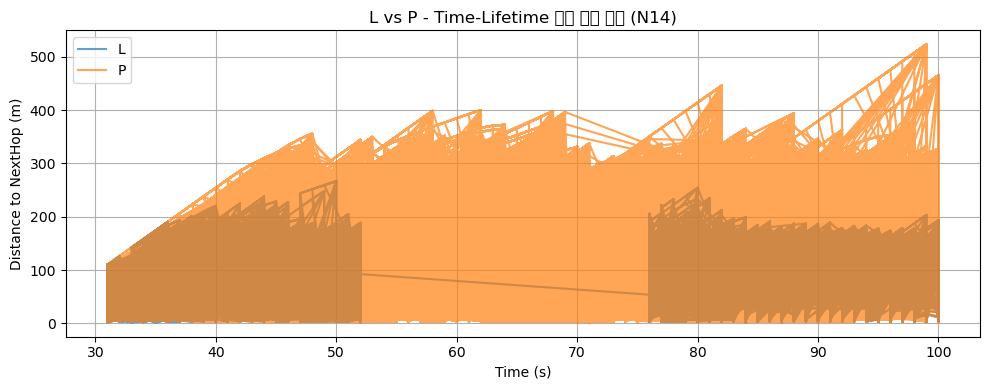

In [22]:
import os
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 100.0

results = {}

for method in methods:
    print(f"[INFO] 분석 시작: {method}")
    rt_path = os.path.join(base_path, method, density, speed, node, "routing_table_log.csv")
    pos_path = os.path.join(base_path, method, density, speed, node, "position.csv")

    if not os.path.exists(rt_path) or not os.path.exists(pos_path):
        print(f"[{method}] 파일 없음: {rt_path} 또는 {pos_path}")
        continue

    df_rt = pd.read_csv(rt_path)
    df_pos = pd.read_csv(pos_path)
    df_pos.set_index(["Time", "Node"], inplace=True)

    all_distances = []
    valid_links = 0
    invalid_links = 0
    time_series = []

    for _, row in tqdm(df_rt.iterrows(), total=len(df_rt), desc=f"{method} 경로 추적"):
        node_id = row["Node"]
        nexthop_id = row["NextHop"]
        start_time = int(row["Time"])
        end_time = int(row["Lifetime"])

        for t in range(start_time, int(end_time)):
            try:
                n_pos = df_pos.loc[(t, node_id)]
                nh_pos = df_pos.loc[(t, nexthop_id)]

                dist = sqrt(
                    (n_pos["NodeX"].iloc[0] - nh_pos["NodeX"].iloc[0]) ** 2 +
                    (n_pos["NodeY"].iloc[0] - nh_pos["NodeY"].iloc[0]) ** 2
                )
            except (KeyError, IndexError):
                continue

            all_distances.append((t, dist))
            if dist <= max_tx_dist:
                valid_links += 1
            else:
                invalid_links += 1

    if all_distances:
        times, dists = zip(*all_distances)
        avg_dist = sum(dists) / len(dists)
        invalid_ratio = invalid_links / (valid_links + invalid_links) * 100
        results[method] = {
            "avg_distance": avg_dist,
            "invalid_ratio": invalid_ratio,
            "valid_count": valid_links,
            "invalid_count": invalid_links,
            "total_count": valid_links + invalid_links,
            "times": list(times),
            "distances": list(dists)
        }
    else:
        results[method] = {
            "avg_distance": None,
            "invalid_ratio": None,
            "valid_count": 0,
            "invalid_count": 0,
            "total_count": 0,
            "times": [],
            "distances": []
        }

for method in methods:
    r = results[method]
    print(f"\n[{method} 방식]")
    print(f" - 평균 거리: {r['avg_distance']:.2f} m" if r['avg_distance'] else " - 평균 거리: 측정 불가")
    print(f" - 유효 링크 수: {r['valid_count']}개")
    print(f" - 무효 링크 수: {r['invalid_count']}개")
    print(f" - 무효 비율: {r['invalid_ratio']:.2f}%\n" if r['invalid_ratio'] is not None else " - 무효 비율: 측정 불가")

plt.figure(figsize=(10, 4))
for method in methods:
    if results[method]["distances"]:
        plt.plot(results[method]["times"], results[method]["distances"], label=method, alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Distance to NextHop (m)")
plt.title(f"L vs P - Time-Lifetime 기반 거리 분석 ({node})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


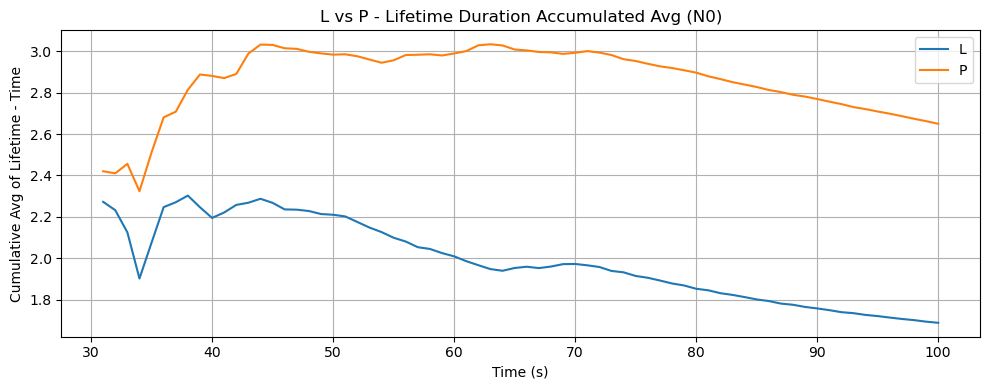

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N0"
methods = ["L", "P"]

results = {}

for method in methods:
    rt_path = os.path.join(base_path, method, density, speed, node, "routing_table_log.csv")
    if not os.path.exists(rt_path):
        continue

    df = pd.read_csv(rt_path)
    df["LifetimeDiff"] = df["Lifetime"] - df["Time"]
    grouped = df.groupby("Time")["LifetimeDiff"].mean().sort_index()

    cumulative_sum = grouped.cumsum()
    cumulative_avg = cumulative_sum / range(1, len(cumulative_sum) + 1)

    results[method] = {
        "times": grouped.index.tolist(),
        "cumulative_avg": cumulative_avg.tolist()
    }

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["times"], results[method]["cumulative_avg"], label=method)
plt.xlabel("Time (s)")
plt.ylabel("Cumulative Avg of Lifetime - Time")
plt.title(f"L vs P - Lifetime Duration Accumulated Avg ({node})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Method: L | Node: N14 | File: position.csv ===
     조건: Density=D400, Speed=S30, MaxTx=100.0m
[L] Time= 31 | Avg=70.06m | Std=14.77 | Invalid=405/2386 (16.97%)
[L] Time= 32 | Avg=70.07m | Std=12.41 | Invalid=834/4869 (17.13%)
[L] Time= 33 | Avg=72.26m | Std=11.77 | Invalid=1080/5632 (19.18%)
[L] Time= 34 | Avg=72.46m | Std=12.31 | Invalid=1097/5586 (19.64%)
[L] Time= 35 | Avg=75.57m | Std=12.19 | Invalid=1540/6241 (24.68%)
[L] Time= 36 | Avg=76.88m | Std=12.57 | Invalid=1586/6410 (24.74%)
[L] Time= 37 | Avg=77.91m | Std=13.49 | Invalid=1703/6558 (25.97%)
[L] Time= 38 | Avg=79.82m | Std=13.49 | Invalid=2022/7073 (28.59%)
[L] Time= 39 | Avg=79.95m | Std=14.30 | Invalid=1941/7076 (27.43%)
[L] Time= 40 | Avg=80.18m | Std=14.49 | Invalid=2031/7226 (28.11%)
[L] Time= 41 | Avg=80.11m | Std=14.98 | Invalid=2013/7267 (27.70%)
[L] Time= 42 | Avg=78.43m | Std=15.05 | Invalid=1835/6890 (26.63%)
[L] Time= 43 | Avg=79.56m | Std=14.92 | Invalid=1975/7115 (27.76%)
[L] Time= 44 | Avg=78.95m | Std=

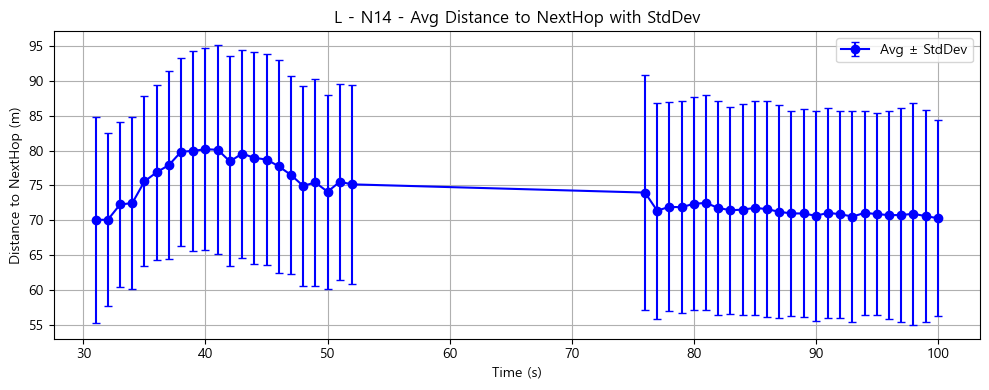

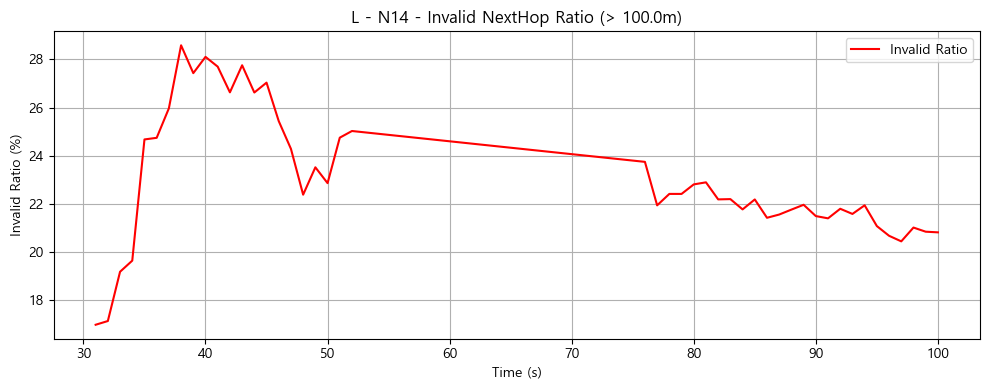


=== Method: P | Node: N14 | File: position.csv ===
     조건: Density=D400, Speed=S30, MaxTx=100.0m
[P] Time= 31 | Avg=70.29m | Std=14.80 | Invalid=416/2523 (16.49%)
[P] Time= 32 | Avg=71.17m | Std=12.21 | Invalid=773/4361 (17.73%)
[P] Time= 33 | Avg=72.23m | Std=12.07 | Invalid=1002/5129 (19.54%)
[P] Time= 34 | Avg=73.23m | Std=12.46 | Invalid=1120/5288 (21.18%)
[P] Time= 35 | Avg=75.50m | Std=12.56 | Invalid=1365/5620 (24.29%)
[P] Time= 36 | Avg=76.95m | Std=13.28 | Invalid=1476/5816 (25.38%)
[P] Time= 37 | Avg=78.89m | Std=13.70 | Invalid=1751/6236 (28.08%)
[P] Time= 38 | Avg=80.24m | Std=13.74 | Invalid=1888/6610 (28.56%)
[P] Time= 39 | Avg=81.76m | Std=14.64 | Invalid=1966/6773 (29.03%)
[P] Time= 40 | Avg=82.98m | Std=14.67 | Invalid=2196/7340 (29.92%)
[P] Time= 41 | Avg=84.05m | Std=15.26 | Invalid=2258/7464 (30.25%)
[P] Time= 42 | Avg=85.17m | Std=16.17 | Invalid=2417/7652 (31.59%)
[P] Time= 43 | Avg=86.34m | Std=16.59 | Invalid=2550/7865 (32.42%)
[P] Time= 44 | Avg=87.42m | Std=

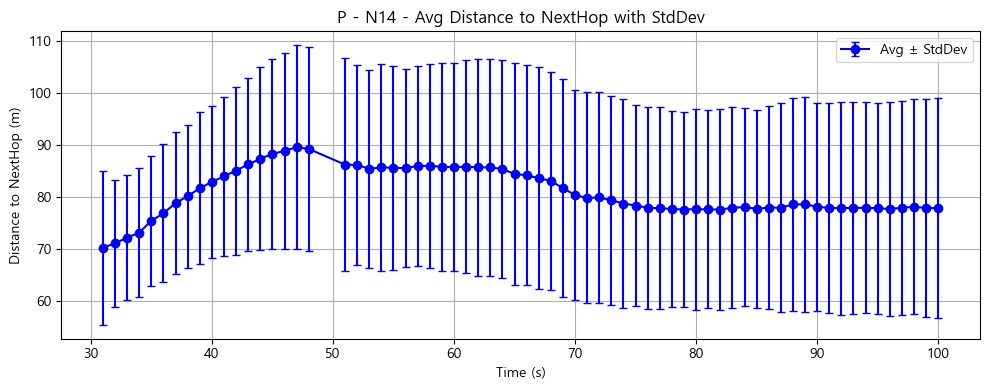

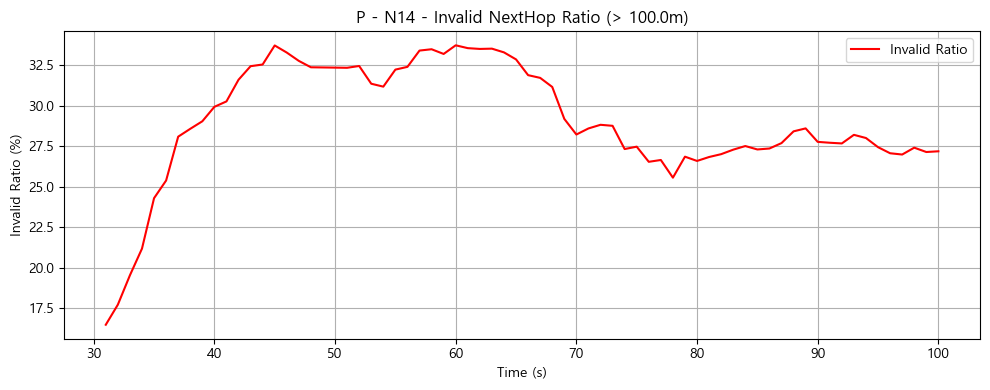

In [82]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 100.0

for method in methods:
    pos_path = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(pos_path):
        print(f"[{method}] 위치 파일 없음: {pos_path}")
        continue

    df_all = pd.read_csv(pos_path)
    print(f"\n=== Method: {method} | Node: {node} | File: position.csv ===")
    print(f"     조건: Density={density}, Speed={speed}, MaxTx={max_tx_dist}m")

    times = sorted(df_all["Time"].unique())
    avg_distances, std_distances, invalid_ratios, times_for_plot = [], [], [], []

    for t in times:
        df_t = df_all[df_all["Time"] == t]
        if df_t.empty:
            avg_distances.append(0)
            std_distances.append(0)
            invalid_ratios.append(0)
            times_for_plot.append(t)
            continue

        node_groups = df_t.groupby("Node")
        per_node_avgs = []
        invalid, total = 0, 0

        for _, group in node_groups:
            dists = []
            for _, row in group.iterrows():
                dist = sqrt((row["NodeX"] - row["NextHopX"])**2 + (row["NodeY"] - row["NextHopY"])**2)
                dists.append(dist)
                total += 1
                if dist > max_tx_dist:
                    invalid += 1

            if dists:
                per_node_avgs.append(np.mean(dists))

        overall_avg = np.mean(per_node_avgs) if per_node_avgs else 0
        overall_std = np.std(per_node_avgs) if per_node_avgs else 0
        ratio = (invalid / total) * 100.0 if total > 0 else 0.0

        avg_distances.append(overall_avg)
        std_distances.append(overall_std)
        invalid_ratios.append(ratio)
        times_for_plot.append(t)

        print(f"[{method}] Time={t:>3} | Avg={overall_avg:.2f}m | Std={overall_std:.2f} | Invalid={invalid}/{total} ({ratio:.2f}%)")

    plt.figure(figsize=(10, 4))
    plt.errorbar(times_for_plot, avg_distances, yerr=std_distances, fmt='-o', capsize=3, label="Avg ± StdDev", color='blue')
    plt.xlabel("Time (s)")
    plt.ylabel("Distance to NextHop (m)")
    plt.title(f"{method} - {node} - Avg Distance to NextHop with StdDev")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(times_for_plot, invalid_ratios, label="Invalid Ratio", color='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Invalid Ratio (%)")
    plt.title(f"{method} - {node} - Invalid NextHop Ratio (> {max_tx_dist}m)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


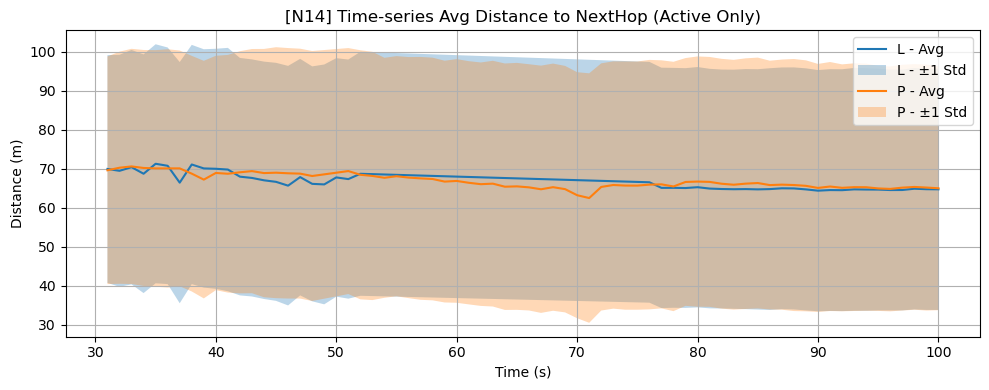

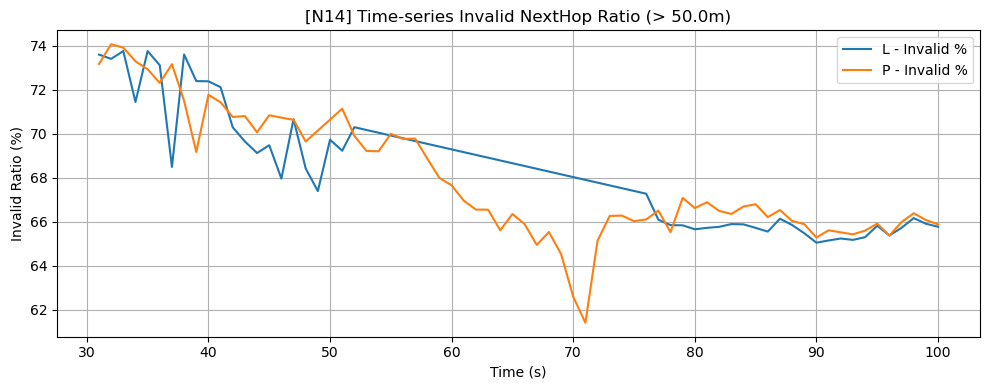

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 50.0

results = {}

for method in methods:
    pos_file = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(pos_file):
        print(f"[{method}] 파일 없음: {pos_file}")
        continue

    df = pd.read_csv(pos_file)

    df = df[df["Active"] == True]

    avg_dists, std_dists, invalid_ratios, time_list = [], [], [], []

    for time in sorted(df["Time"].unique()):
        df_t = df[df["Time"] == time]
        dists = []

        for _, row in df_t.iterrows():
            dist = sqrt((row["NodeX"] - row["NextHopX"]) ** 2 + (row["NodeY"] - row["NextHopY"]) ** 2)
            dists.append(dist)

        if dists:
            avg_dists.append(np.mean(dists))
            std_dists.append(np.std(dists))
            invalid_ratios.append((np.sum(np.array(dists) > max_tx_dist) / len(dists)) * 100)
        else:
            avg_dists.append(0)
            std_dists.append(0)
            invalid_ratios.append(0)

        time_list.append(time)

    results[method] = {
        "Time": time_list,
        "Avg": avg_dists,
        "Std": std_dists,
        "Invalid": invalid_ratios
    }

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["Time"], results[method]["Avg"], label=f"{method} - Avg")
        plt.fill_between(results[method]["Time"],
                         np.array(results[method]["Avg"]) - np.array(results[method]["Std"]),
                         np.array(results[method]["Avg"]) + np.array(results[method]["Std"]),
                         alpha=0.3, label=f"{method} - ±1 Std")
plt.title(f"[{node}] Time-series Avg Distance to NextHop (Active Only)")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["Time"], results[method]["Invalid"], label=f"{method} - Invalid %")
plt.title(f"[{node}] Time-series Invalid NextHop Ratio (> {max_tx_dist}m)")
plt.xlabel("Time (s)")
plt.ylabel("Invalid Ratio (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


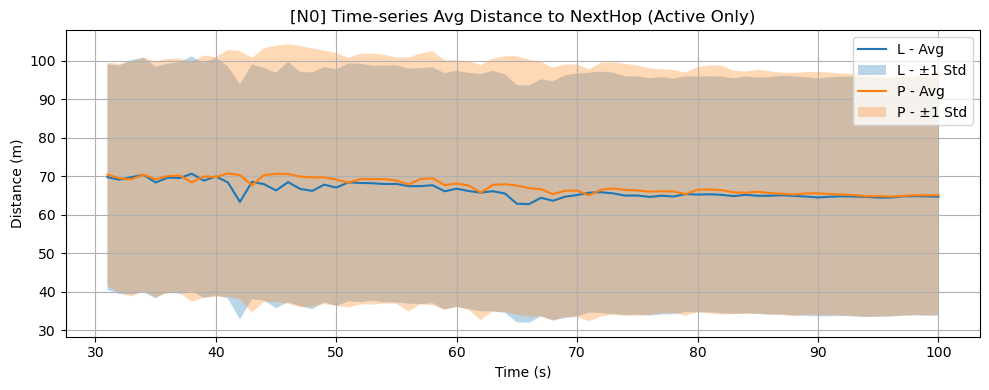

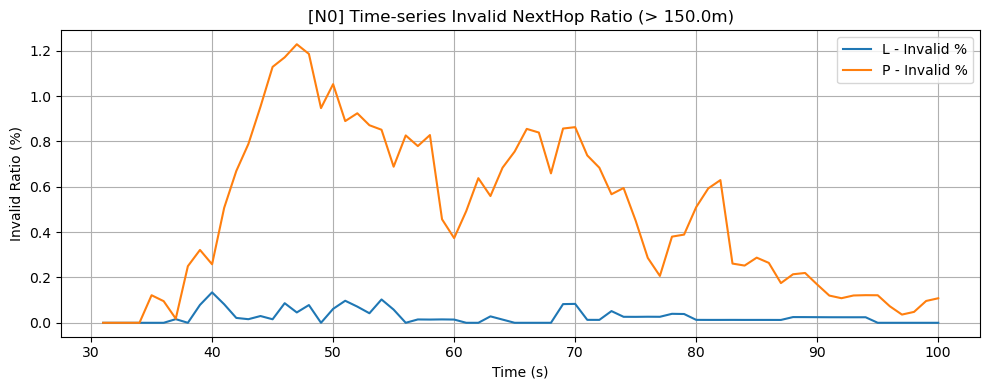

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N0"
methods = ["L", "P"]
max_tx_dist = 150.0

results = {}

for method in methods:
    pos_file = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(pos_file):
        print(f"[{method}] 파일 없음: {pos_file}")
        continue

    df = pd.read_csv(pos_file)

    df = df[df["Active"] == True]

    avg_dists, std_dists, invalid_ratios, time_list = [], [], [], []

    for time in sorted(df["Time"].unique()):
        df_t = df[df["Time"] == time]
        dists = []

        for _, row in df_t.iterrows():
            dist = sqrt((row["NodeX"] - row["NextHopX"]) ** 2 + (row["NodeY"] - row["NextHopY"]) ** 2)
            dists.append(dist)

        if dists:
            avg_dists.append(np.mean(dists))
            std_dists.append(np.std(dists))
            invalid_ratios.append((np.sum(np.array(dists) > max_tx_dist) / len(dists)) * 100)
        else:
            avg_dists.append(0)
            std_dists.append(0)
            invalid_ratios.append(0)

        time_list.append(time)

    results[method] = {
        "Time": time_list,
        "Avg": avg_dists,
        "Std": std_dists,
        "Invalid": invalid_ratios
    }

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["Time"], results[method]["Avg"], label=f"{method} - Avg")
        plt.fill_between(results[method]["Time"],
                         np.array(results[method]["Avg"]) - np.array(results[method]["Std"]),
                         np.array(results[method]["Avg"]) + np.array(results[method]["Std"]),
                         alpha=0.3, label=f"{method} - ±1 Std")
plt.title(f"[{node}] Time-series Avg Distance to NextHop (Active Only)")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in methods:
    if method in results:
        plt.plot(results[method]["Time"], results[method]["Invalid"], label=f"{method} - Invalid %")
plt.title(f"[{node}] Time-series Invalid NextHop Ratio (> {max_tx_dist}m)")
plt.xlabel("Time (s)")
plt.ylabel("Invalid Ratio (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


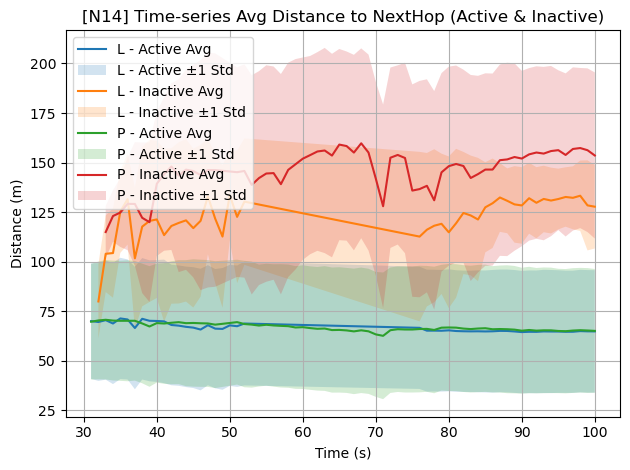

[L - Active] 평균 거리: 66.57 ± 30.69
[L - Inactive] 평균 거리: 122.27 ± 28.44
[P - Active] 평균 거리: 66.84 ± 31.40
[P - Inactive] 평균 거리: 145.76 ± 46.52


In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 100.0

results = {}

for method in methods:
    file_path = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(file_path):
        print(f"[{method}] 파일 없음: {file_path}")
        continue

    df = pd.read_csv(file_path)
    df["Distance"] = np.sqrt((df["NodeX"] - df["NextHopX"])**2 + (df["NodeY"] - df["NextHopY"])**2)

    for active_state in [True, False]:
        key = f"{method}_{active_state}"
        df_sub = df[df["Active"] == active_state]

        grouped = df_sub.groupby("Time")["Distance"]
        avg_dist = grouped.mean()
        std_dist = grouped.std()

        results[key] = {
            "avg": avg_dist,
            "std": std_dist,
            "mean_avg": avg_dist.mean(),
            "mean_std": std_dist.mean()
        }

        label = f"{method} - {'Active' if active_state else 'Inactive'}"
        plt.plot(avg_dist.index, avg_dist.values, label=f"{label} Avg")
        plt.fill_between(std_dist.index,
                         avg_dist - std_dist,
                         avg_dist + std_dist,
                         alpha=0.2, label=f"{label} ±1 Std")

plt.title(f"[{node}] Time-series Avg Distance to NextHop (Active & Inactive)")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for method in methods:
    for active_state in [True, False]:
        key = f"{method}_{active_state}"
        label = f"{method} - {'Active' if active_state else 'Inactive'}"
        print(f"[{label}] 평균 거리: {results[key]['mean_avg']:.2f} ± {results[key]['mean_std']:.2f}")


In [50]:
import os
import pandas as pd
import numpy as np

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 100.0

results = {}

for method in methods:
    file_path = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(file_path):
        print(f"[{method}] 파일 없음: {file_path}")
        continue

    df = pd.read_csv(file_path)
    if "Active" not in df.columns:
        print(f"[{method}] 'Active' 열 없음")
        continue

    df["Distance"] = np.sqrt((df["NodeX"] - df["NextHopX"])**2 + (df["NodeY"] - df["NextHopY"])**2)

    df_active = df[df["Active"] == True]
    df_inactive = df[df["Active"] == False]

    results[method] = {
        "Active_Mean": df_active["Distance"].mean(),
        "Active_Std": df_active["Distance"].std(),
        "Inactive_Mean": df_inactive["Distance"].mean(),
        "Inactive_Std": df_inactive["Distance"].std()
    }

for method in methods:
    if method not in results:
        continue
    r = results[method]
    print(f"[{method} - Active] 평균 거리: {r['Active_Mean']:.2f} ± {r['Active_Std']:.2f}")
    print(f"[{method} - Inactive] 평균 거리: {r['Inactive_Mean']:.2f} ± {r['Inactive_Std']:.2f}")


[L - Active] 평균 거리: 66.24 ± 30.81
[L - Inactive] 평균 거리: 121.76 ± 33.73
[P - Active] 평균 거리: 66.59 ± 31.54
[P - Inactive] 평균 거리: 146.77 ± 50.08


In [63]:
import os
import pandas as pd
import numpy as np
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N0"
methods = ["L", "P"]

send_log_name = "aodv_send_log.csv"
pos_log_name = "position.csv"

send_columns = ["Time", "Node", "PacketName", "Duration", "PacketType",
                "SrcAddr", "DestAddr", "TTL", "Delay", "CastType"]

results = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)
    send_file = os.path.join(node_path, send_log_name)
    pos_file = os.path.join(node_path, pos_log_name)

    if not os.path.exists(send_file) or not os.path.exists(pos_file):
        print(f"[{method}] 파일 없음: {send_file} 또는 {pos_file}")
        continue

    df_send = pd.read_csv(send_file, names=send_columns)
    df_pos = pd.read_csv(pos_file)

    df_send["Time"] = df_send["Time"].round(0).astype(int)
    df_pos["Time"] = df_pos["Time"].round(0).astype(int)

    grouped_pos = df_pos.groupby(["Time", "Node"])

    method_result = {
        "Active": [],
        "Inactive": []
    }

    for _, row in df_send.iterrows():
        time = row["Time"]
        node_name = row["Node"]

        try:
            df_t = grouped_pos.get_group((time, node_name))
        except KeyError:
            continue

        for _, r in df_t.iterrows():
            dist = sqrt((r["NodeX"] - r["NextHopX"])**2 + (r["NodeY"] - r["NextHopY"])**2)
            status = "Active" if r["Active"] else "Inactive"
            method_result[status].append(dist)

    results[method] = {
        status: {
            "mean": np.mean(d) if d else 0,
            "std": np.std(d) if d else 0,
            "count": len(d)
        }
        for status, d in method_result.items()
    }

for m in methods:
    for s in ["Active", "Inactive"]:
        r = results[m][s]
        print(f"[{m} - {s}] 평균 거리: {r['mean']:.2f} ± {r['std']:.2f} (n={r['count']})")


[L - Active] 평균 거리: 66.79 ± 30.77 (n=380730)
[L - Inactive] 평균 거리: 116.36 ± 37.95 (n=59835)
[P - Active] 평균 거리: 67.81 ± 32.15 (n=682448)
[P - Inactive] 평균 거리: 146.14 ± 53.49 (n=155624)


In [76]:
import os
import pandas as pd
import numpy as np
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]

send_log_name = "aodv_send_log.csv"
pos_log_name = "position.csv"

send_columns = ["Time", "Node", "PacketName", "Duration", "PacketType",
                "SrcAddr", "DestAddr", "TTL", "Delay", "CastType"]

packet_types = {
    "inet::aodv::Rrep": "RREP",
    "inet::aodv::Rreq": "RREQ",
    "inet::aodv::Rerr": "RERR",
    "HELLO": "Hello"
}

results = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)
    send_file = os.path.join(node_path, send_log_name)
    pos_file = os.path.join(node_path, pos_log_name)

    if not os.path.exists(send_file) or not os.path.exists(pos_file):
        print(f"[{method}] 파일 없음: {send_file} 또는 {pos_file}")
        continue

    df_send = pd.read_csv(send_file, names=send_columns)
    df_pos = pd.read_csv(pos_file)

    df_send["Time"] = df_send["Time"].round(0).astype(int)
    df_pos["Time"] = df_pos["Time"].round(0).astype(int)

    grouped_pos = df_pos.groupby(["Time", "Node"])

    method_result = {
        pkt: {"Active": [], "Inactive": []}
        for pkt in packet_types.values()
    }

    for _, row in df_send.iterrows():
        packet_type = packet_types.get(row["PacketType"])
        if packet_type is None:
            continue

        time = row["Time"]
        node_name = row["Node"]

        try:
            df_t = grouped_pos.get_group((time, node_name))
        except KeyError:
            continue

        for _, r in df_t.iterrows():
            dist = sqrt((r["NodeX"] - r["NextHopX"])**2 + (r["NodeY"] - r["NextHopY"])**2)
            status = "Active" if r["Active"] else "Inactive"
            method_result[packet_type][status].append(dist)

    results[method] = {
        pkt: {
            status: {
                "mean": np.mean(d) if d else 0,
                "std": np.std(d) if d else 0,
                "count": len(d)
            }
            for status, d in status_dict.items()
        }
        for pkt, status_dict in method_result.items()
    }

for m in methods:
    for pkt in ["RREP", "RREQ", "RERR", "Hello"]:
        for s in ["Active", "Inactive"]:
            r = results[m][pkt][s]
            print(f"[{m} - {pkt} - {s}] 평균 거리: {r['mean']:.2f} ± {r['std']:.2f} (n={r['count']})")


[L - RREP - Active] 평균 거리: 76.57 ± 27.92 (n=4695)
[L - RREP - Inactive] 평균 거리: 118.42 ± 34.74 (n=808)
[L - RREQ - Active] 평균 거리: 70.03 ± 29.91 (n=36243)
[L - RREQ - Inactive] 평균 거리: 120.16 ± 33.16 (n=4331)
[L - RERR - Active] 평균 거리: 75.43 ± 27.99 (n=441)
[L - RERR - Inactive] 평균 거리: 118.07 ± 29.68 (n=73)
[L - Hello - Active] 평균 거리: 65.98 ± 30.83 (n=168042)
[L - Hello - Inactive] 평균 거리: 121.28 ± 34.17 (n=22401)
[P - RREP - Active] 평균 거리: 74.29 ± 28.96 (n=1832)
[P - RREP - Inactive] 평균 거리: 133.69 ± 47.72 (n=387)
[P - RREQ - Active] 평균 거리: 69.45 ± 31.05 (n=56433)
[P - RREQ - Inactive] 평균 거리: 134.77 ± 50.43 (n=14027)
[P - RERR - Active] 평균 거리: 76.40 ± 31.12 (n=796)
[P - RERR - Inactive] 평균 거리: 150.82 ± 48.99 (n=185)
[P - Hello - Active] 평균 거리: 66.41 ± 31.59 (n=251311)
[P - Hello - Inactive] 평균 거리: 147.19 ± 50.19 (n=56801)


In [71]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

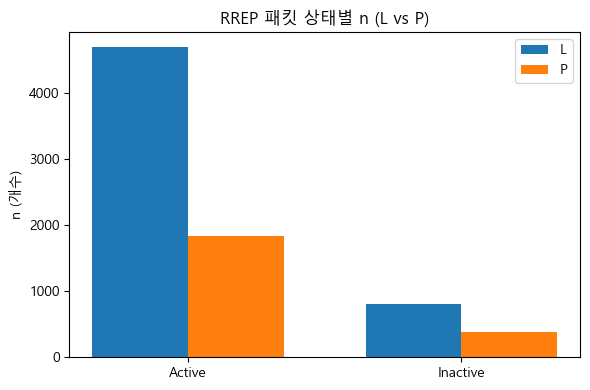

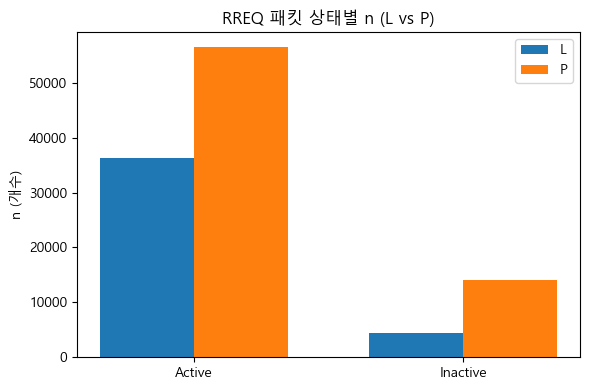

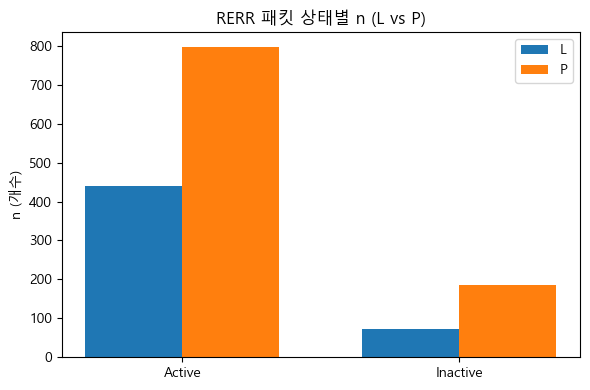

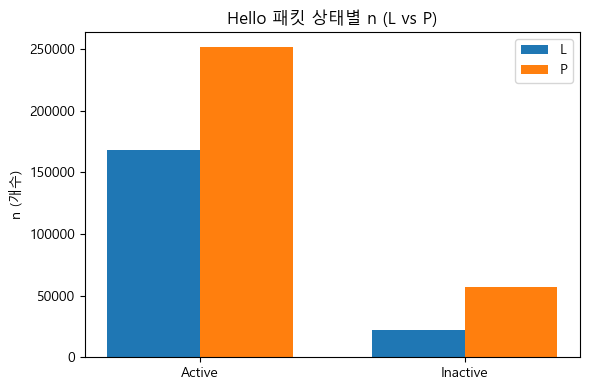

In [75]:
import os
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]

send_log_name = "aodv_send_log.csv"
pos_log_name = "position.csv"

send_columns = ["Time", "Node", "PacketName", "Duration", "PacketType",
                "SrcAddr", "DestAddr", "TTL", "Delay", "CastType"]

packet_types = {
    "inet::aodv::Rrep": "RREP",
    "inet::aodv::Rreq": "RREQ",
    "inet::aodv::Rerr": "RERR",
    "HELLO": "Hello"
}

results = {m: {pkt: {"Active": 0, "Inactive": 0} for pkt in packet_types.values()} for m in methods}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)
    send_file = os.path.join(node_path, send_log_name)
    pos_file = os.path.join(node_path, pos_log_name)

    if not os.path.exists(send_file) or not os.path.exists(pos_file):
        continue

    df_send = pd.read_csv(send_file, names=send_columns)
    df_pos = pd.read_csv(pos_file)

    df_send["Time"] = df_send["Time"].round(0).astype(int)
    df_pos["Time"] = df_pos["Time"].round(0).astype(int)

    grouped_pos = df_pos.groupby(["Time", "Node"])

    for _, row in df_send.iterrows():
        packet_type = packet_types.get(row["PacketType"])
        if packet_type is None:
            continue

        time = row["Time"]
        node_name = row["Node"]

        try:
            df_t = grouped_pos.get_group((time, node_name))
        except KeyError:
            continue

        for _, r in df_t.iterrows():
            status = "Active" if r["Active"] else "Inactive"
            results[method][packet_type][status] += 1

pkt_list = ["RREP", "RREQ", "RERR", "Hello"]
status_list = ["Active", "Inactive"]

for pkt in pkt_list:
    fig, ax = plt.subplots(figsize=(6,4))
    vals_L = [results["L"][pkt][s] for s in status_list]
    vals_P = [results["P"][pkt][s] for s in status_list]
    x = np.arange(len(status_list))
    width = 0.35
    ax.bar(x - width/2, vals_L, width, label="L")
    ax.bar(x + width/2, vals_P, width, label="P")
    ax.set_xticks(x)
    ax.set_xticklabels(status_list)
    ax.set_ylabel("n (개수)")
    ax.set_title(f"{pkt} 패킷 상태별 n (L vs P)")
    ax.legend()
    plt.tight_layout()
    plt.show()


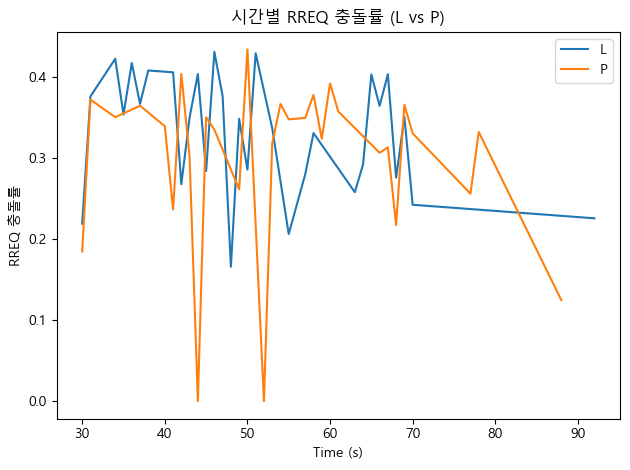

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N0"
methods = ["L", "P"]
sinr_file_name = "sinr_all_log.csv"

results = {}

for method in methods:
    file_path = os.path.join(base_path, method, density, speed, node, sinr_file_name)
    if not os.path.exists(file_path):
        continue

    df = pd.read_csv(file_path)
    df.columns = [col.strip() for col in df.columns]

    df["Time"] = df["Time"].astype(float).round(0).astype(int)
    df["Success"] = df["Success"].astype(str).str.strip().str.lower()
    df["Packet"] = df["Packet"].astype(str).str.strip()

    df["isCollision"] = df["Success"] == "false"

    df_rreq = df[df["Packet"] == "aodv::Rreq"]

    total_per_time = df_rreq.groupby("Time").size()
    collision_per_time = df_rreq[df_rreq["isCollision"]].groupby("Time").size()
    collision_rate = (collision_per_time / total_per_time).fillna(0)

    results[method] = collision_rate

for method in methods:
    if method in results:
        plt.plot(results[method].index, results[method].values, label=f"{method}")

plt.xlabel("Time (s)")
plt.ylabel("RREQ 충돌률")
plt.title("시간별 RREQ 충돌률 (L vs P)")
plt.legend()
plt.tight_layout()
plt.show()


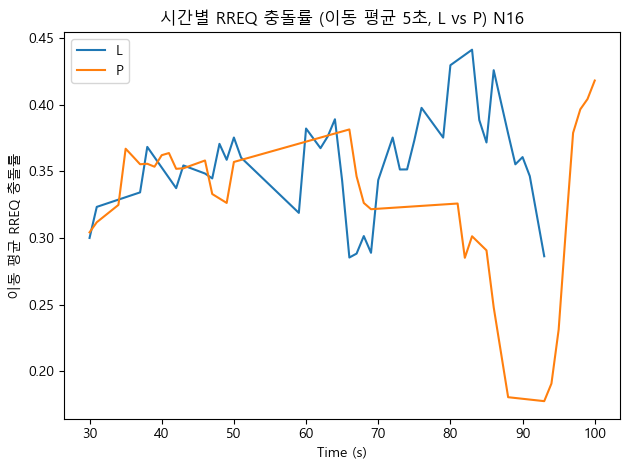

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N16"
methods = ["L", "P"]
sinr_file_name = "sinr_all_log.csv"
window_size = 5 

results = {}

for method in methods:
    file_path = os.path.join(base_path, method, density, speed, node, sinr_file_name)
    if not os.path.exists(file_path):
        continue

    df = pd.read_csv(file_path)
    df.columns = [col.strip() for col in df.columns]

    df["Time"] = df["Time"].astype(float).round(0).astype(int)
    df["Success"] = df["Success"].astype(str).str.strip().str.lower()
    df["Packet"] = df["Packet"].astype(str).str.strip()

    df["isCollision"] = df["Success"] == "false"

    df_rreq = df[df["Packet"] == "aodv::Rreq"]

    total_per_time = df_rreq.groupby("Time").size()
    collision_per_time = df_rreq[df_rreq["isCollision"]].groupby("Time").size()
    collision_rate = (collision_per_time / total_per_time).fillna(0)

    smoothed = collision_rate.rolling(window=window_size, center=True, min_periods=1).mean()
    results[method] = smoothed

for method in methods:
    if method in results:
        plt.plot(results[method].index, results[method].values, label=f"{method}")

plt.xlabel("Time (s)")
plt.ylabel("이동 평균 RREQ 충돌률")
plt.title(f"시간별 RREQ 충돌률 (이동 평균 {window_size}초, L vs P) {node}")
plt.legend()
plt.tight_layout()
plt.show()


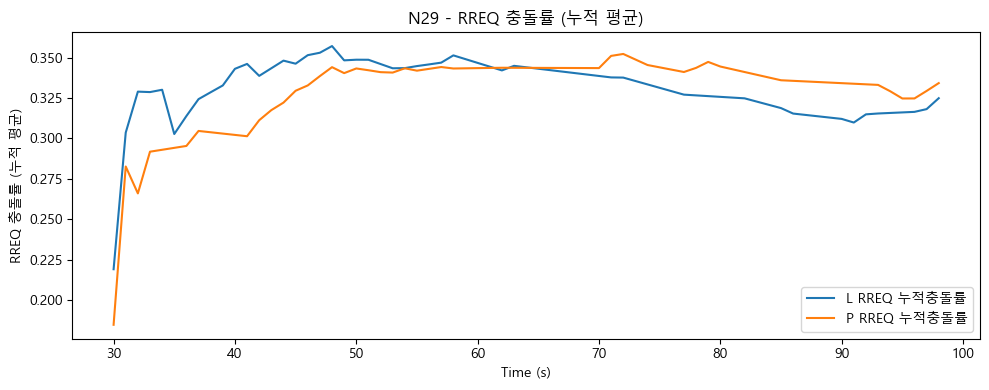

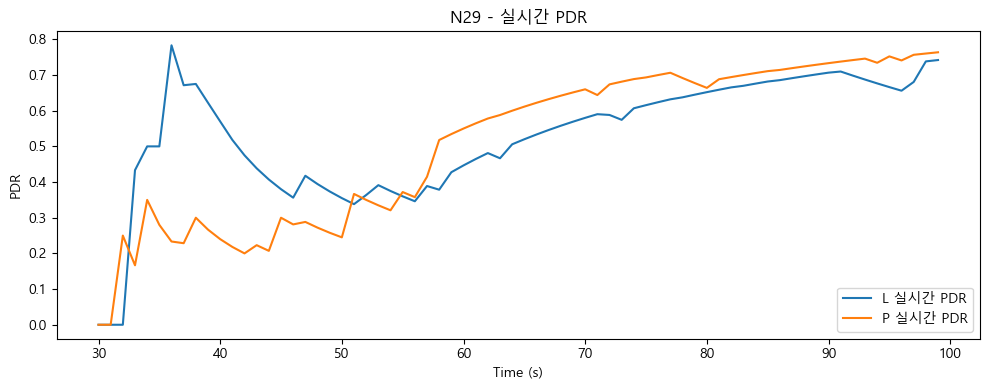

In [80]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N29"
methods = ["L", "P"]
sinr_file_name = "sinr_all_log.csv"
pdr_file_name = "PDR.txt"

collision_result = {}
pdr_result = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)
    sinr_file = os.path.join(node_path, sinr_file_name)
    pdr_file = os.path.join(node_path, pdr_file_name)

    if os.path.exists(sinr_file):
        df = pd.read_csv(sinr_file)
        df.columns = [col.strip() for col in df.columns]

        df["Time"] = df["Time"].astype(float).round(0).astype(int)
        df["Success"] = df["Success"].astype(str).str.strip().str.lower()
        df["Packet"] = df["Packet"].astype(str).str.strip()
        df["isCollision"] = df["Success"] == "false"

        df_rreq = df[df["Packet"] == "aodv::Rreq"]
        total_per_time = df_rreq.groupby("Time").size()
        collision_per_time = df_rreq[df_rreq["isCollision"]].groupby("Time").size()
        collision_rate = (collision_per_time / total_per_time).fillna(0)
        collision_cumulative = collision_rate.expanding(min_periods=1).mean()
        collision_result[method] = collision_cumulative

    if os.path.exists(pdr_file):
        df_pdr = pd.read_csv(pdr_file, sep=":", header=None, names=["Time", "PDR"])
        df_pdr["Time"] = df_pdr["Time"].astype(int)
        df_pdr["PDR"] = pd.to_numeric(df_pdr["PDR"], errors="coerce").fillna(0)
        df_pdr = df_pdr.set_index("Time")
        df_pdr["PDR"] = df_pdr["PDR"] / 100.0
        pdr_result[method] = df_pdr["PDR"]

plt.figure(figsize=(10, 4))
for method in collision_result:
    plt.plot(collision_result[method].index, collision_result[method].values, label=f"{method} RREQ 누적충돌률")
plt.xlabel("Time (s)")
plt.ylabel("RREQ 충돌률 (누적 평균)")
plt.title(f"{node} - RREQ 충돌률 (누적 평균)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in pdr_result:
    plt.plot(pdr_result[method].index, pdr_result[method].values, label=f"{method} 실시간 PDR")
plt.xlabel("Time (s)")
plt.ylabel("PDR")
plt.title(f"{node} - 실시간 PDR")
plt.legend()
plt.tight_layout()
plt.show()


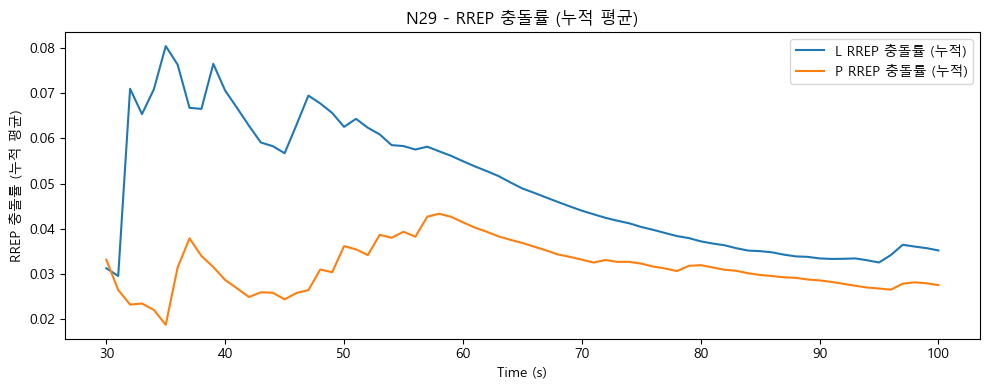

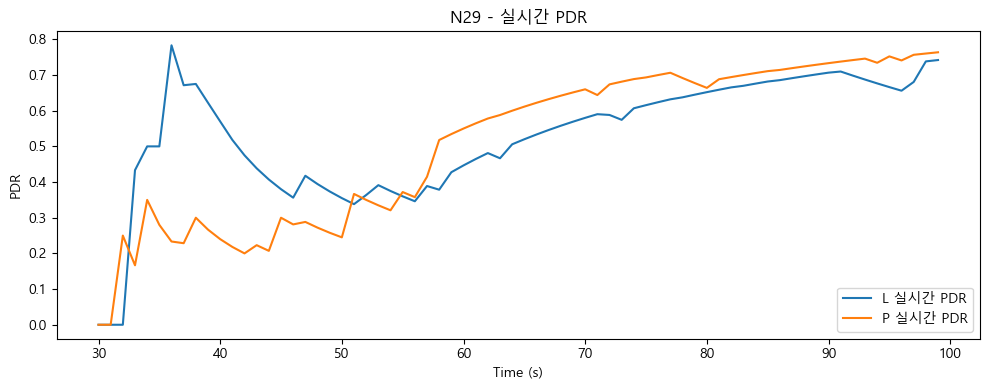

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N29"
methods = ["L", "P"]
sinr_file_name = "sinr_all_log.csv"
pdr_file_name = "PDR.txt"

collision_result = {}
pdr_result = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)
    sinr_file = os.path.join(node_path, sinr_file_name)
    pdr_file = os.path.join(node_path, pdr_file_name)

    if os.path.exists(sinr_file):
        df = pd.read_csv(sinr_file)
        df.columns = [col.strip() for col in df.columns]

        df["Time"] = df["Time"].astype(float).round(0).astype(int)
        df["Success"] = df["Success"].astype(str).str.strip().str.lower()
        df["Packet"] = df["Packet"].astype(str).str.strip()
        df["isCollision"] = df["Success"] == "false"

        df_rrep = df[df["Packet"] == "aodv::Rrep"]
        total_per_time = df_rrep.groupby("Time").size()
        collision_per_time = df_rrep[df_rrep["isCollision"]].groupby("Time").size()
        collision_rate = (collision_per_time / total_per_time).fillna(0)
        collision_cumulative = collision_rate.expanding(min_periods=1).mean()
        collision_result[method] = collision_cumulative

    if os.path.exists(pdr_file):
        df_pdr = pd.read_csv(pdr_file, sep=":", header=None, names=["Time", "PDR"])
        df_pdr["Time"] = df_pdr["Time"].astype(int)
        df_pdr["PDR"] = pd.to_numeric(df_pdr["PDR"], errors="coerce").fillna(0)
        df_pdr = df_pdr.set_index("Time")
        df_pdr["PDR"] = df_pdr["PDR"] / 100.0
        pdr_result[method] = df_pdr["PDR"]

plt.figure(figsize=(10, 4))
for method in collision_result:
    plt.plot(collision_result[method].index, collision_result[method].values, label=f"{method} RREP 충돌률 (누적)")
plt.xlabel("Time (s)")
plt.ylabel("RREP 충돌률 (누적 평균)")
plt.title(f"{node} - RREP 충돌률 (누적 평균)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in pdr_result:
    plt.plot(pdr_result[method].index, pdr_result[method].values, label=f"{method} 실시간 PDR")
plt.xlabel("Time (s)")
plt.ylabel("PDR")
plt.title(f"{node} - 실시간 PDR")
plt.legend()
plt.tight_layout()
plt.show()


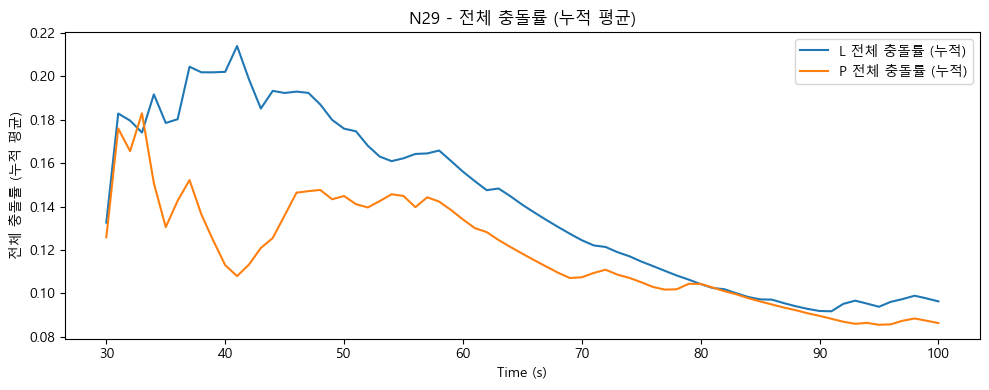

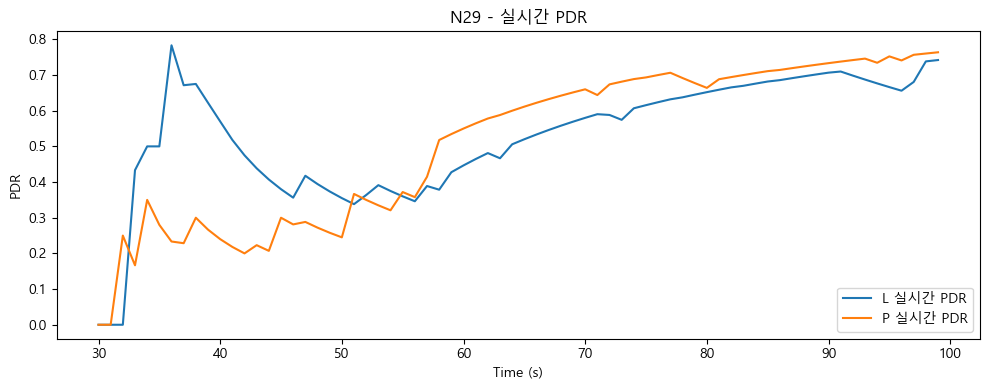

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N29"
methods = ["L", "P"]
sinr_file_name = "sinr_all_log.csv"
pdr_file_name = "PDR.txt"

collision_result = {}
pdr_result = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)
    sinr_file = os.path.join(node_path, sinr_file_name)
    pdr_file = os.path.join(node_path, pdr_file_name)

    if os.path.exists(sinr_file):
        df = pd.read_csv(sinr_file)
        df.columns = [col.strip() for col in df.columns]

        df["Time"] = df["Time"].astype(float).round(0).astype(int)
        df["Success"] = df["Success"].astype(str).str.strip().str.lower()
        df["isCollision"] = df["Success"] == "false"

        total_per_time = df.groupby("Time").size()
        collision_per_time = df[df["isCollision"]].groupby("Time").size()
        collision_rate = (collision_per_time / total_per_time).fillna(0)
        collision_cumulative = collision_rate.expanding(min_periods=1).mean()
        collision_result[method] = collision_cumulative

    if os.path.exists(pdr_file):
        df_pdr = pd.read_csv(pdr_file, sep=":", header=None, names=["Time", "PDR"])
        df_pdr["Time"] = df_pdr["Time"].astype(int)
        df_pdr["PDR"] = pd.to_numeric(df_pdr["PDR"], errors="coerce").fillna(0)
        df_pdr = df_pdr.set_index("Time")
        df_pdr["PDR"] = df_pdr["PDR"] / 100.0
        pdr_result[method] = df_pdr["PDR"]

plt.figure(figsize=(10, 4))
for method in collision_result:
    plt.plot(collision_result[method].index, collision_result[method].values, label=f"{method} 전체 충돌률 (누적)")
plt.xlabel("Time (s)")
plt.ylabel("전체 충돌률 (누적 평균)")
plt.title(f"{node} - 전체 충돌률 (누적 평균)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in pdr_result:
    plt.plot(pdr_result[method].index, pdr_result[method].values, label=f"{method} 실시간 PDR")
plt.xlabel("Time (s)")
plt.ylabel("PDR")
plt.title(f"{node} - 실시간 PDR")
plt.legend()
plt.tight_layout()
plt.show()


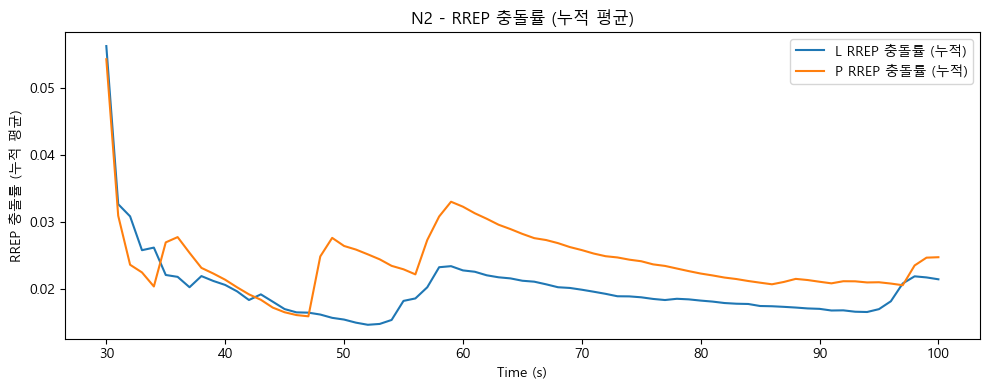

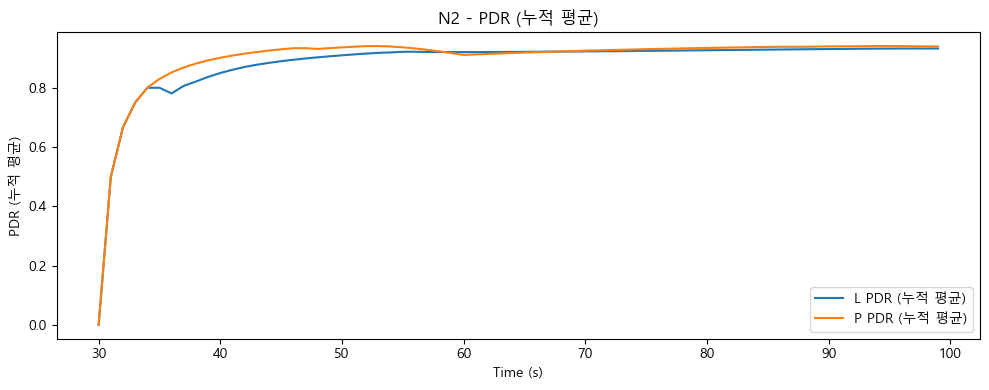

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N2"
methods = ["L", "P"]
sinr_file_name = "sinr_all_log.csv"
pdr_file_name = "PDR.txt"

collision_result = {}
pdr_result = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)
    sinr_file = os.path.join(node_path, sinr_file_name)
    pdr_file = os.path.join(node_path, pdr_file_name)

    if os.path.exists(sinr_file):
        df = pd.read_csv(sinr_file)
        df.columns = [col.strip() for col in df.columns]

        df["Time"] = df["Time"].astype(float).round(0).astype(int)
        df["Success"] = df["Success"].astype(str).str.strip().str.lower()
        df["Packet"] = df["Packet"].astype(str).str.strip()
        df["isCollision"] = df["Success"] == "false"

        df_rrep = df[df["Packet"] == "aodv::Rrep"]
        total_per_time = df_rrep.groupby("Time").size()
        collision_per_time = df_rrep[df_rrep["isCollision"]].groupby("Time").size()
        collision_rate = (collision_per_time / total_per_time).fillna(0)
        collision_cumulative = collision_rate.expanding(min_periods=1).mean()
        collision_result[method] = collision_cumulative

    if os.path.exists(pdr_file):
        df_pdr = pd.read_csv(pdr_file, sep=":", header=None, names=["Time", "PDR"])
        df_pdr["Time"] = df_pdr["Time"].astype(int)
        df_pdr["PDR"] = pd.to_numeric(df_pdr["PDR"], errors="coerce").fillna(0)
        df_pdr = df_pdr.set_index("Time")
        df_pdr["PDR"] = df_pdr["PDR"] / 100.0
        pdr_cumulative = df_pdr["PDR"].expanding(min_periods=1).mean()
        pdr_result[method] = pdr_cumulative

plt.figure(figsize=(10, 4))
for method in collision_result:
    plt.plot(collision_result[method].index, collision_result[method].values, label=f"{method} RREP 충돌률 (누적)")
plt.xlabel("Time (s)")
plt.ylabel("RREP 충돌률 (누적 평균)")
plt.title(f"{node} - RREP 충돌률 (누적 평균)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in pdr_result:
    plt.plot(pdr_result[method].index, pdr_result[method].values, label=f"{method} PDR (누적 평균)")
plt.xlabel("Time (s)")
plt.ylabel("PDR (누적 평균)")
plt.title(f"{node} - PDR (누적 평균)")
plt.legend()
plt.tight_layout()
plt.show()


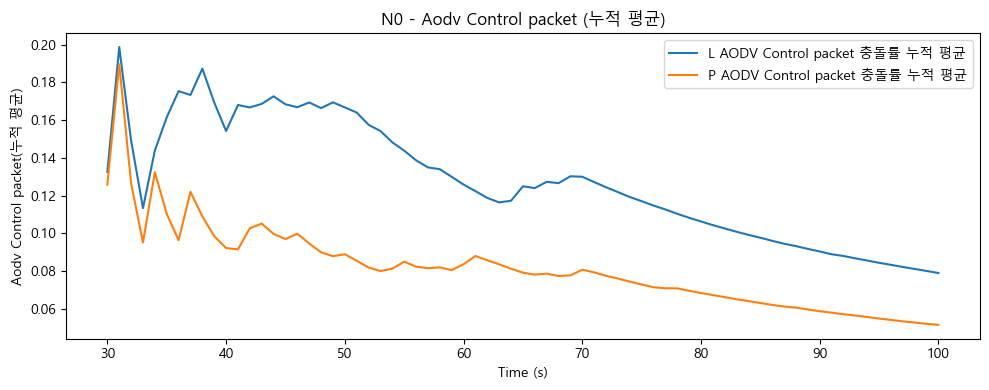

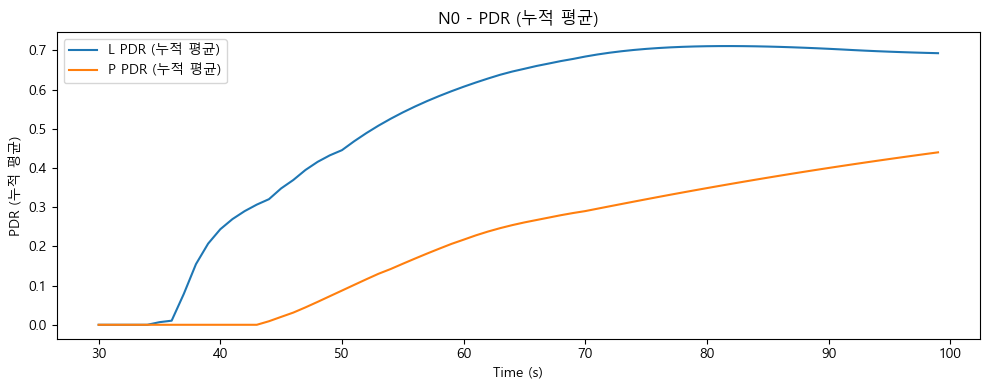

In [92]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N0"
methods = ["L", "P"]
sinr_file_name = "sinr_all_log.csv"
pdr_file_name = "PDR.txt"

collision_result = {}
pdr_result = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)
    sinr_file = os.path.join(node_path, sinr_file_name)
    pdr_file = os.path.join(node_path, pdr_file_name)

    if os.path.exists(sinr_file):
        df = pd.read_csv(sinr_file)
        df.columns = [col.strip() for col in df.columns]

        df["Time"] = df["Time"].astype(float).round(0).astype(int)
        df["Success"] = df["Success"].astype(str).str.strip().str.lower()
        df["isCollision"] = df["Success"] == "false"

        total_per_time = df.groupby("Time").size()
        collision_per_time = df[df["isCollision"]].groupby("Time").size()
        collision_rate = (collision_per_time / total_per_time).fillna(0)
        collision_cumulative = collision_rate.expanding(min_periods=1).mean()
        collision_result[method] = collision_cumulative

    if os.path.exists(pdr_file):
        df_pdr = pd.read_csv(pdr_file, sep=":", header=None, names=["Time", "PDR"])
        df_pdr["Time"] = df_pdr["Time"].astype(int)
        df_pdr["PDR"] = pd.to_numeric(df_pdr["PDR"], errors="coerce").fillna(0)
        df_pdr = df_pdr.set_index("Time")
        df_pdr["PDR"] = df_pdr["PDR"] / 100.0
        pdr_cumulative = df_pdr["PDR"].expanding(min_periods=1).mean()
        pdr_result[method] = pdr_cumulative

plt.figure(figsize=(10, 4))
for method in collision_result:
    plt.plot(collision_result[method].index, collision_result[method].values, label=f"{method} AODV Control packet 충돌률 누적 평균")
plt.xlabel("Time (s)")
plt.ylabel("Aodv Control packet(누적 평균)")
plt.title(f"{node} - Aodv Control packet (누적 평균)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for method in pdr_result:
    plt.plot(pdr_result[method].index, pdr_result[method].values, label=f"{method} PDR (누적 평균)")
plt.xlabel("Time (s)")
plt.ylabel("PDR (누적 평균)")
plt.title(f"{node} - PDR (누적 평균)")
plt.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


L 파일 없음: C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09\aodv_send_log.csv
P 파일 없음: C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09\aodv_send_log.csv


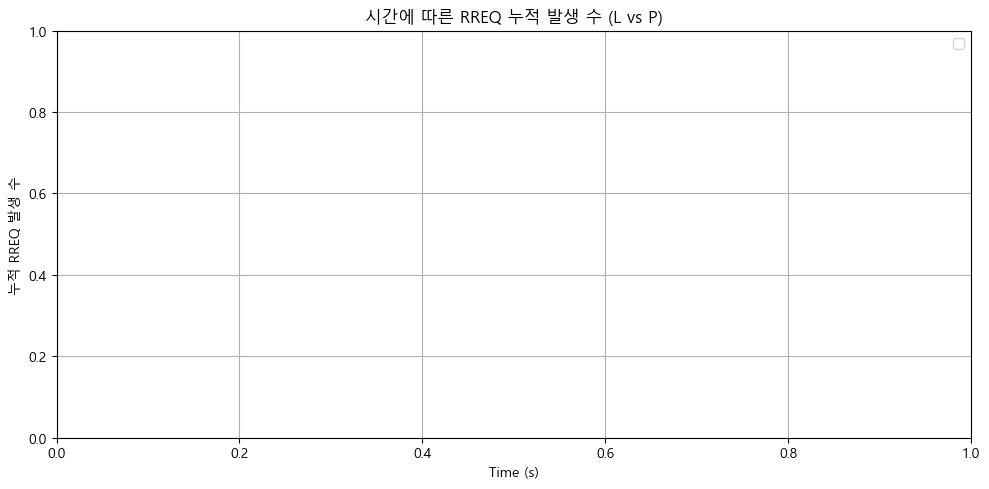

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
send_log_files = {
    "L": os.path.join(base_path, "aodv_send_log.csv"),
    "P": os.path.join(base_path, "aodv_send_log.csv")
}

rreq_data = {}

for method, path in send_log_files.items():
    if not os.path.exists(path):
        print(f"{method} 파일 없음: {path}")
        continue

    df = pd.read_csv(path)
    df = df[df["PacketType"].str.contains("RREQ", na=False)]
    df["Time"] = df["Time"].astype(float).astype(int)
    rreq_per_time = df.groupby("Time").size().cumsum()
    rreq_data[method] = rreq_per_time

plt.figure(figsize=(10, 5))
for method, data in rreq_data.items():
    plt.plot(data.index, data.values, label=f"{method} RREQ 누적 발생 수")
plt.xlabel("Time (s)")
plt.ylabel("누적 RREQ 발생 수")
plt.title("시간에 따른 RREQ 누적 발생 수 (L vs P)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


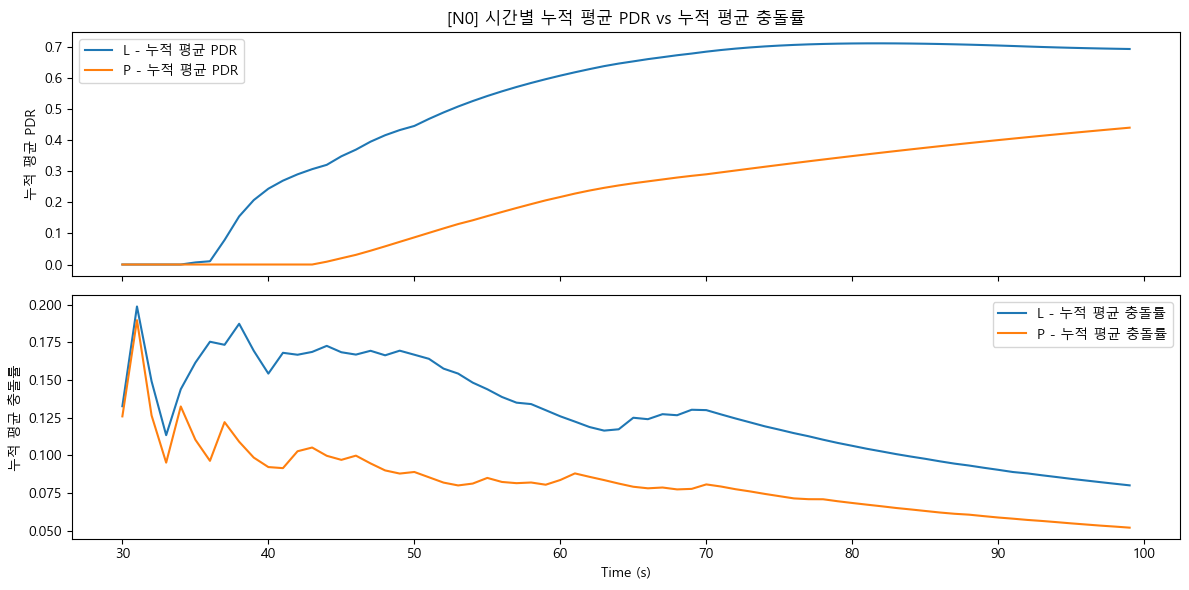

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 사용자 경로 설정
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N0"
methods = ["L", "P"]

sinr_file_name = "sinr_all_log.csv"
pdr_file_name = "PDR.txt"

pdr_series = {}
collision_series = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)

    pdr_path = os.path.join(node_path, pdr_file_name)
    if os.path.exists(pdr_path):
        df_pdr = pd.read_csv(pdr_path, sep=":", header=None, names=["Time", "PDR"])
        df_pdr["Time"] = df_pdr["Time"].astype(int)
        df_pdr["PDR"] = pd.to_numeric(df_pdr["PDR"], errors="coerce").fillna(0)
        df_pdr["PDR"] = df_pdr["PDR"] / 100.0
        pdr_series[method] = df_pdr.set_index("Time")["PDR"]

    sinr_path = os.path.join(node_path, sinr_file_name)
    if os.path.exists(sinr_path):
        df = pd.read_csv(sinr_path)
        df.columns = [col.strip() for col in df.columns]
        df["Time"] = df["Time"].astype(float).round(0).astype(int)
        df["Success"] = df["Success"].astype(str).str.strip().str.lower()
        df["Packet"] = df["Packet"].astype(str).str.strip()
        df["isCollision"] = df["Success"] == "false"

        total_per_time = df.groupby("Time").size()
        collision_per_time = df[df["isCollision"]].groupby("Time").size()
        collision_rate = (collision_per_time / total_per_time).fillna(0)
        collision_series[method] = collision_rate

common_times = sorted(
    set(pdr_series["L"].index) & set(pdr_series["P"].index) &
    set(collision_series["L"].index) & set(collision_series["P"].index)
)

pdr_cum = {
    m: pd.Series([pdr_series[m].get(t, np.nan) for t in common_times], index=common_times).expanding(min_periods=1).mean()
    for m in methods
}
collision_cum = {
    m: pd.Series([collision_series[m].get(t, np.nan) for t in common_times], index=common_times).expanding(min_periods=1).mean()
    for m in methods
}

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for m in methods:
    axs[0].plot(common_times, pdr_cum[m], label=f"{m} - 누적 평균 PDR")
    axs[1].plot(common_times, collision_cum[m], label=f"{m} - 누적 평균 충돌률")

axs[0].set_ylabel("누적 평균 PDR")
axs[1].set_ylabel("누적 평균 충돌률")
axs[1].set_xlabel("Time (s)")
axs[0].legend()
axs[1].legend()
axs[0].set_title(f"[{node}] 시간별 누적 평균 PDR vs 누적 평균 충돌률")
plt.tight_layout()
plt.show()


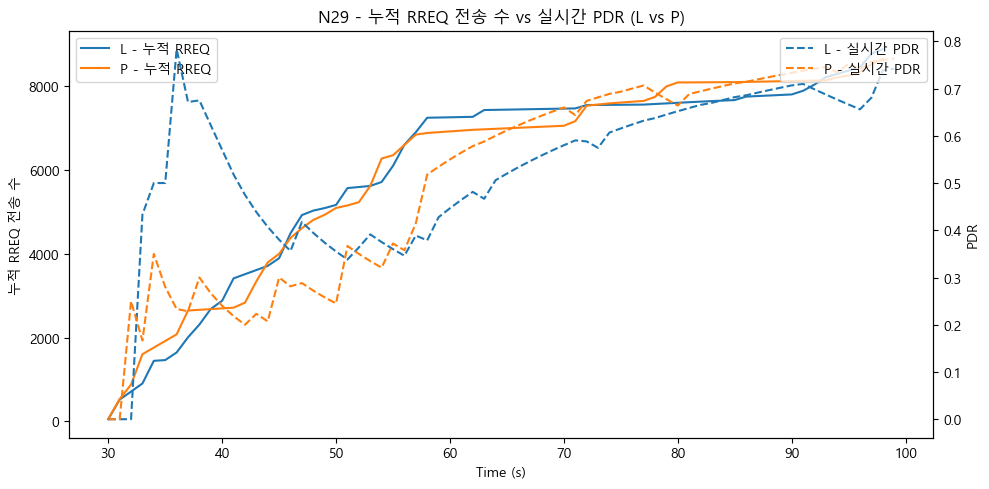

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N29"
methods = ["L", "P"]

send_log_name = "aodv_send_log.csv"
pdr_log_name = "PDR.txt"

default_send_columns = ["Time", "Node", "PacketName", "Duration", "PacketType",
                        "SrcAddr", "DestAddr", "TTL", "Delay", "CastType"]

rreq_cumulative = {}
pdr_time_series = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)

    send_path = os.path.join(node_path, send_log_name)
    pdr_path = os.path.join(node_path, pdr_log_name)

    if os.path.exists(send_path):
        df_send = pd.read_csv(send_path, names=default_send_columns)
        df_send["Time"] = df_send["Time"].astype(float).round(0).astype(int)
        df_send["PacketType"] = df_send["PacketType"].astype(str).str.strip()
        df_rreq = df_send[df_send["PacketType"].str.contains("Rreq", case=False)]
        rreq_cum = df_rreq.groupby("Time").size().cumsum()
        rreq_cumulative[method] = rreq_cum

    if os.path.exists(pdr_path):
        df_pdr = pd.read_csv(pdr_path, sep=":", header=None, names=["Time", "PDR"])
        df_pdr["Time"] = df_pdr["Time"].astype(int)
        df_pdr["PDR"] = pd.to_numeric(df_pdr["PDR"], errors="coerce").fillna(0) / 100.0
        pdr_time_series[method] = df_pdr.set_index("Time")["PDR"]

fig, ax1 = plt.subplots(figsize=(10, 5))

for method in rreq_cumulative:
    ax1.plot(rreq_cumulative[method].index, rreq_cumulative[method].values, label=f"{method} - 누적 RREQ")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("누적 RREQ 전송 수")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
for method in pdr_time_series:
    ax2.plot(pdr_time_series[method].index, pdr_time_series[method].values, label=f"{method} - 실시간 PDR", linestyle="--")
ax2.set_ylabel("PDR")
ax2.legend(loc="upper right")

plt.title(f"{node} - 누적 RREQ 전송 수 vs 실시간 PDR (L vs P)")
plt.tight_layout()
plt.show()


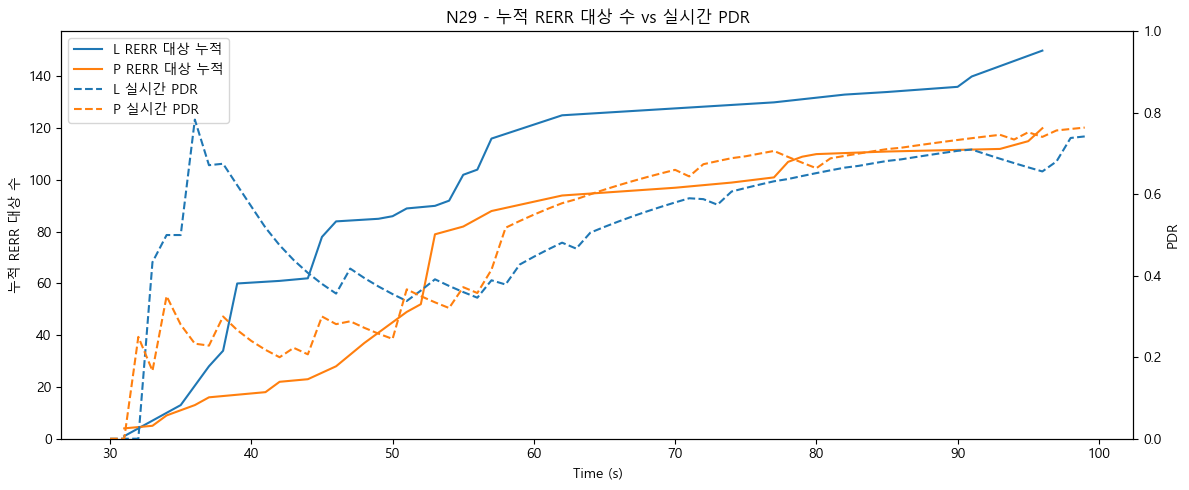

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
methods = ["L", "P"]
node = "N29"
density = "D400"
speed = "S30"

pdr_result = {}
rerr_result = {}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)

    pdr_file = os.path.join(node_path, "PDR.txt")
    if os.path.exists(pdr_file):
        df_pdr = pd.read_csv(pdr_file, sep=":", header=None, names=["Time", "PDR"])
        df_pdr["Time"] = df_pdr["Time"].astype(int)
        df_pdr["PDR"] = pd.to_numeric(df_pdr["PDR"], errors="coerce").fillna(0) / 100.0
        pdr_result[method] = df_pdr.set_index("Time")["PDR"]

    rerr_file = os.path.join(node_path, "rerr_precursor_log.txt")
    times, dest_counts = [], []
    if os.path.exists(rerr_file):
        with open(rerr_file, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    parts = line.strip().split(", ")
                    time_str = parts[0].split(":")[1].strip()
                    destinations_str = parts[2].split(":")[1].strip()
                    time = int(float(time_str))
                    count = len(destinations_str.split(";")) if destinations_str else 0
                    times.append(time)
                    dest_counts.append(count)
                except Exception:
                    continue
        df_rerr = pd.DataFrame({"Time": times, "DestCount": dest_counts})
        rerr_result[method] = df_rerr.groupby("Time")["DestCount"].sum().cumsum()

fig, ax1 = plt.subplots(figsize=(12, 5))

for method in methods:
    if method in rerr_result:
        ax1.plot(rerr_result[method].index, rerr_result[method].values, label=f"{method} RERR 대상 누적")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("누적 RERR 대상 수")
ax1.set_ylim(0, None)

ax2 = ax1.twinx()
for method in methods:
    if method in pdr_result:
        ax2.plot(pdr_result[method].index, pdr_result[method].values, linestyle='--', label=f"{method} 실시간 PDR")
ax2.set_ylabel("PDR")
ax2.set_ylim(0, 1.0)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f"{node} - 누적 RERR 대상 수 vs 실시간 PDR")
plt.tight_layout()
plt.show()


In [2]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

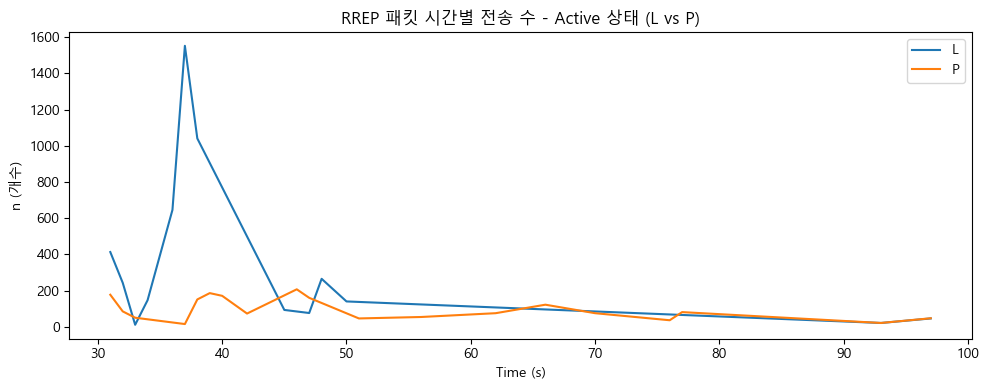

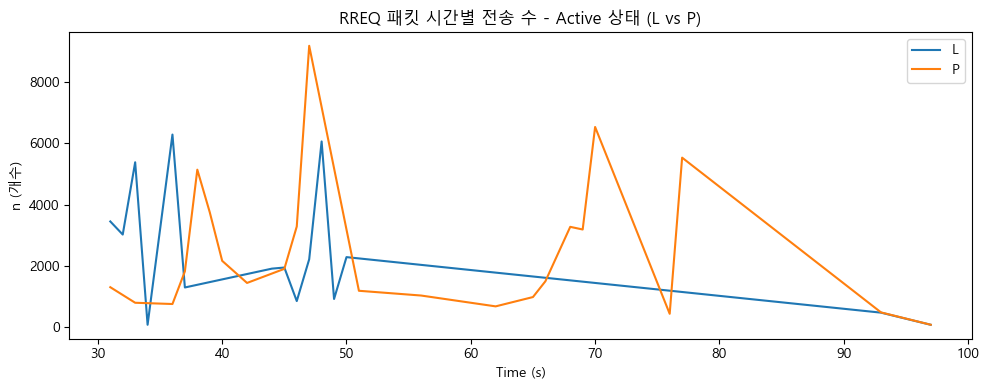

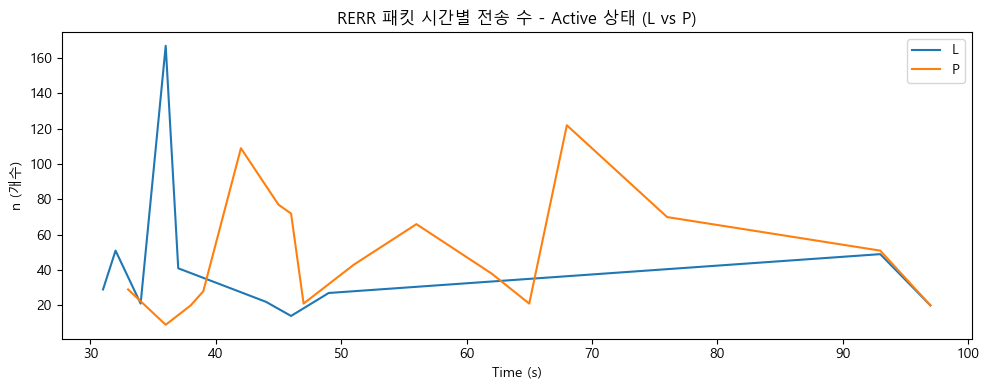

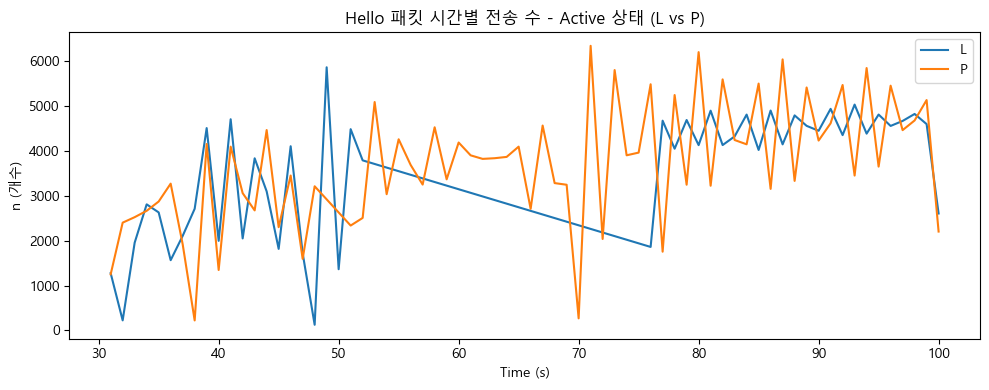

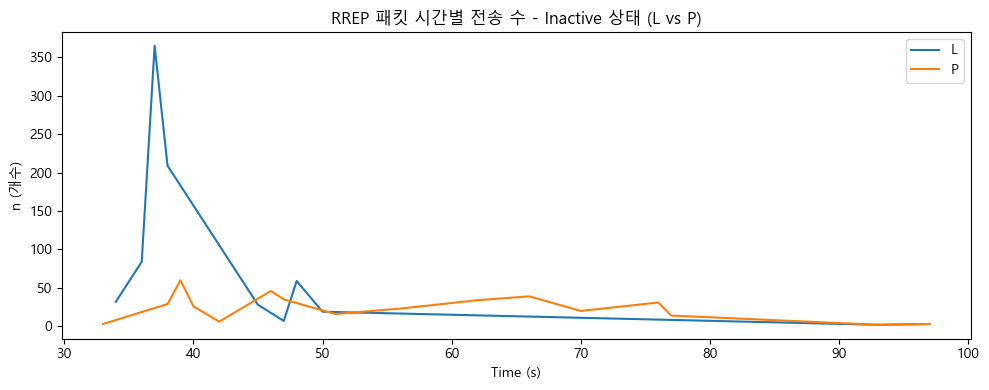

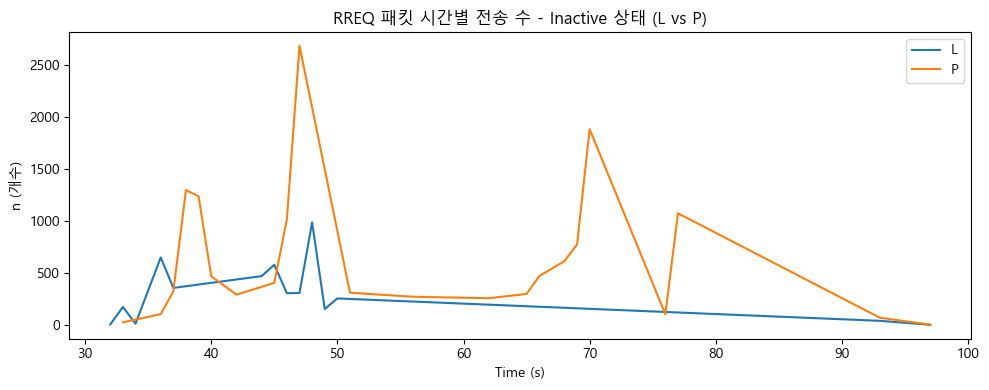

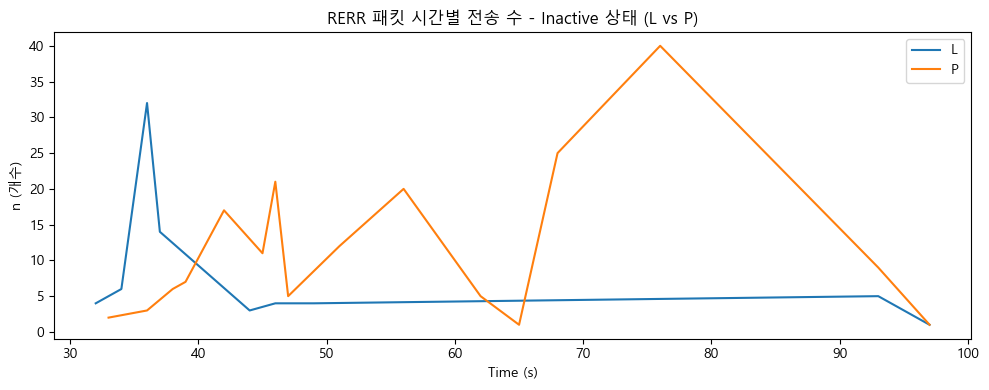

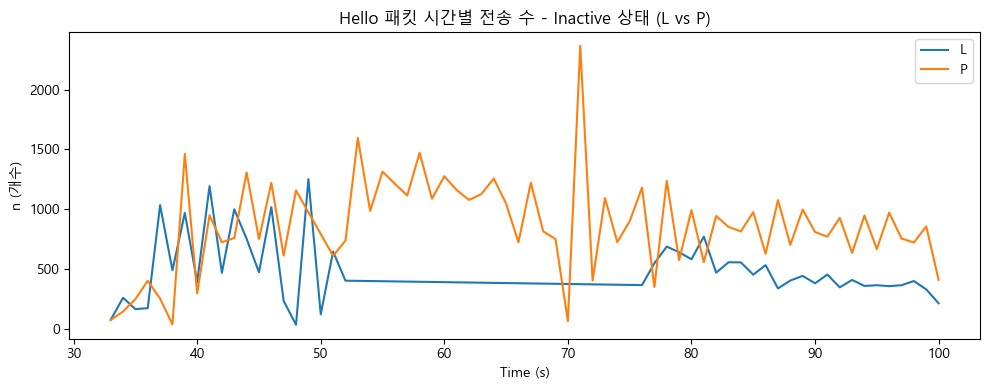

In [4]:
import os
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]

send_log_name = "aodv_send_log.csv"
pos_log_name = "position.csv"

send_columns = ["Time", "Node", "PacketName", "Duration", "PacketType",
                "SrcAddr", "DestAddr", "TTL", "Delay", "CastType"]

packet_types = {
    "inet::aodv::Rrep": "RREP",
    "inet::aodv::Rreq": "RREQ",
    "inet::aodv::Rerr": "RERR",
    "HELLO": "Hello"
}

results = {status: {pkt: {} for pkt in packet_types.values()} for status in ["Active", "Inactive"]}

for method in methods:
    node_path = os.path.join(base_path, method, density, speed, node)
    send_file = os.path.join(node_path, send_log_name)
    pos_file = os.path.join(node_path, pos_log_name)

    if not os.path.exists(send_file) or not os.path.exists(pos_file):
        continue

    df_send = pd.read_csv(send_file, names=send_columns)
    df_pos = pd.read_csv(pos_file)

    df_send["Time"] = df_send["Time"].round(0).astype(int)
    df_pos["Time"] = df_pos["Time"].round(0).astype(int)

    grouped_pos = df_pos.groupby(["Time", "Node"])

    for _, row in df_send.iterrows():
        packet_type = packet_types.get(row["PacketType"])
        if packet_type is None:
            continue

        time = row["Time"]
        node_name = row["Node"]

        try:
            df_t = grouped_pos.get_group((time, node_name))
        except KeyError:
            continue

        for _, r in df_t.iterrows():
            status = "Active" if r["Active"] else "Inactive"
            key = (time, method)
            if key not in results[status][packet_type]:
                results[status][packet_type][key] = 0
            results[status][packet_type][key] += 1

pkt_list = ["RREP", "RREQ", "RERR", "Hello"]
methods = ["L", "P"]
status_list = ["Active", "Inactive"]

for status in status_list:
    for pkt in pkt_list:
        fig, ax = plt.subplots(figsize=(10, 4))
        for method in methods:
            series = {t: count for (t, m), count in results[status][pkt].items() if m == method}
            times = sorted(series.keys())
            counts = [series[t] for t in times]
            ax.plot(times, counts, label=f"{method}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("n (개수)")
        ax.set_title(f"{pkt} 패킷 시간별 전송 수 - {status} 상태 (L vs P)")
        ax.legend()
        plt.tight_layout()
        plt.show()


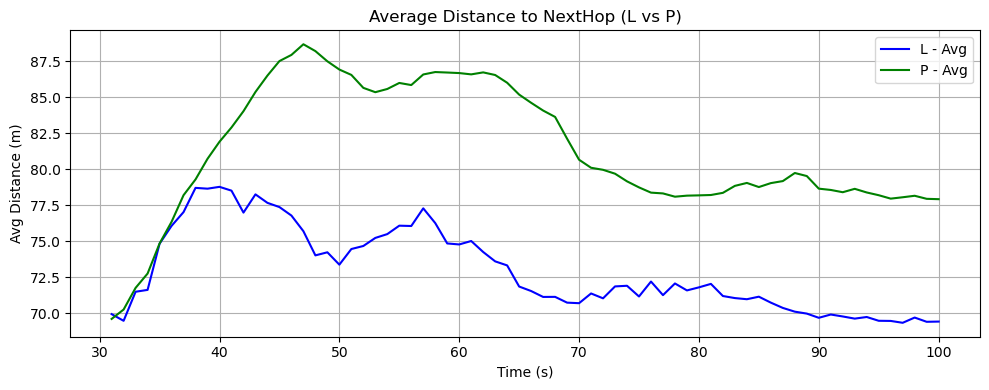

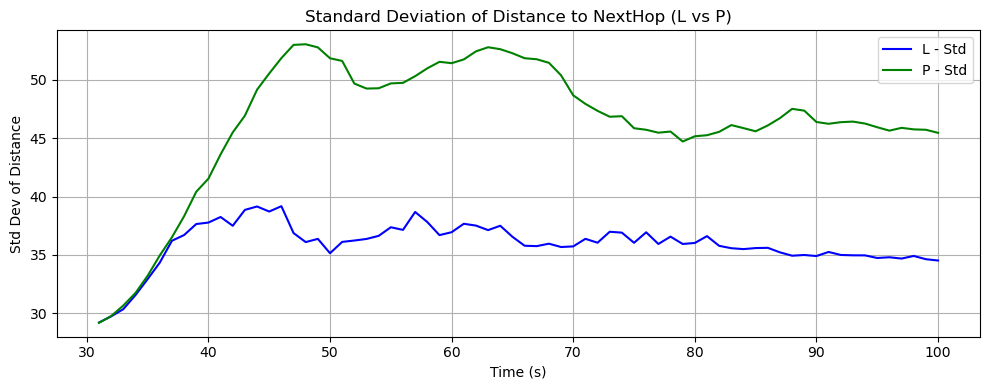

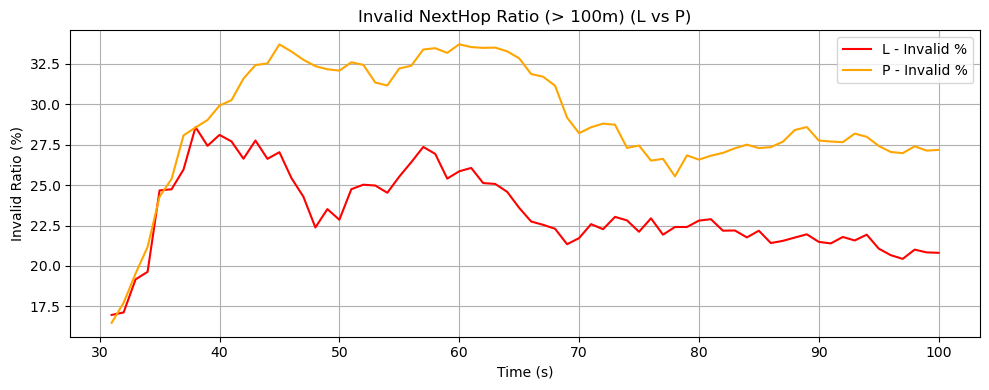

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09"
density = "D400"
speed = "S30"
node = "N14"
methods = ["L", "P"]
max_tx_dist = 100.0

per_method_result = {}

for method in methods:
    pos_path = os.path.join(base_path, method, density, speed, node, "position.csv")
    if not os.path.exists(pos_path):
        print(f"[{method}] 위치 파일 없음: {pos_path}")
        continue

    df_all = pd.read_csv(pos_path)
    times = sorted(df_all["Time"].unique())
    avg_distances, std_distances, invalid_ratios = [], [], []

    for t in times:
        df_t = df_all[df_all["Time"] == t]
        if df_t.empty:
            avg_distances.append(0)
            std_distances.append(0)
            invalid_ratios.append(0)
            continue

        dists = []
        invalid, total = 0, 0

        for _, row in df_t.iterrows():
            dist = sqrt((row["NodeX"] - row["NextHopX"])**2 + (row["NodeY"] - row["NextHopY"])**2)
            dists.append(dist)
            total += 1
            if dist > max_tx_dist:
                invalid += 1

        avg = sum(dists) / len(dists) if dists else 0
        std = pd.Series(dists).std() if dists else 0
        ratio = (invalid / total) * 100.0 if total > 0 else 0.0

        avg_distances.append(avg)
        std_distances.append(std)
        invalid_ratios.append(ratio)

    per_method_result[method] = {
        "times": times,
        "avg": avg_distances,
        "std": std_distances,
        "invalid": invalid_ratios
    }

times = per_method_result["L"]["times"]
plt.figure(figsize=(10, 4))
plt.plot(times, per_method_result["L"]["avg"], label="L - Avg", color='blue')
plt.plot(times, per_method_result["P"]["avg"], label="P - Avg", color='green')
plt.xlabel("Time (s)")
plt.ylabel("Avg Distance (m)")
plt.title("Average Distance to NextHop (L vs P)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(times, per_method_result["L"]["std"], label="L - Std", color='blue')
plt.plot(times, per_method_result["P"]["std"], label="P - Std", color='green')
plt.xlabel("Time (s)")
plt.ylabel("Std Dev of Distance")
plt.title("Standard Deviation of Distance to NextHop (L vs P)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(times, per_method_result["L"]["invalid"], label="L - Invalid %", color='red')
plt.plot(times, per_method_result["P"]["invalid"], label="P - Invalid %", color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Invalid Ratio (%)")
plt.title("Invalid NextHop Ratio (> 100m) (L vs P)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Method: L (N13 - Time-series Avg Distance & Invalid Ratio) ===
[L] Time=31s: AvgDist=640.72m, Invalid=1496 (63.42%), Total=2359
[L] Time=32s: AvgDist=614.76m, Invalid=2990 (62.07%), Total=4817
[L] Time=33s: AvgDist=615.38m, Invalid=3240 (61.73%), Total=5249
[L] Time=34s: AvgDist=605.96m, Invalid=3649 (60.75%), Total=6007
[L] Time=35s: AvgDist=607.11m, Invalid=3788 (61.17%), Total=6193
[L] Time=36s: AvgDist=606.36m, Invalid=3855 (61.07%), Total=6312
[L] Time=37s: AvgDist=605.75m, Invalid=3358 (61.28%), Total=5480
[L] Time=38s: AvgDist=606.48m, Invalid=3522 (60.91%), Total=5782
[L] Time=39s: AvgDist=603.52m, Invalid=3555 (60.18%), Total=5907
[L] Time=40s: AvgDist=600.31m, Invalid=3493 (59.73%), Total=5848
[L] Time=41s: AvgDist=602.02m, Invalid=3502 (60.28%), Total=5810
[L] Time=42s: AvgDist=596.40m, Invalid=3295 (59.82%), Total=5508
[L] Time=43s: AvgDist=598.23m, Invalid=3659 (59.87%), Total=6112
[L] Time=44s: AvgDist=597.32m, Invalid=3554 (60.27%), Total=5897
[L] Time=45s: AvgDist=

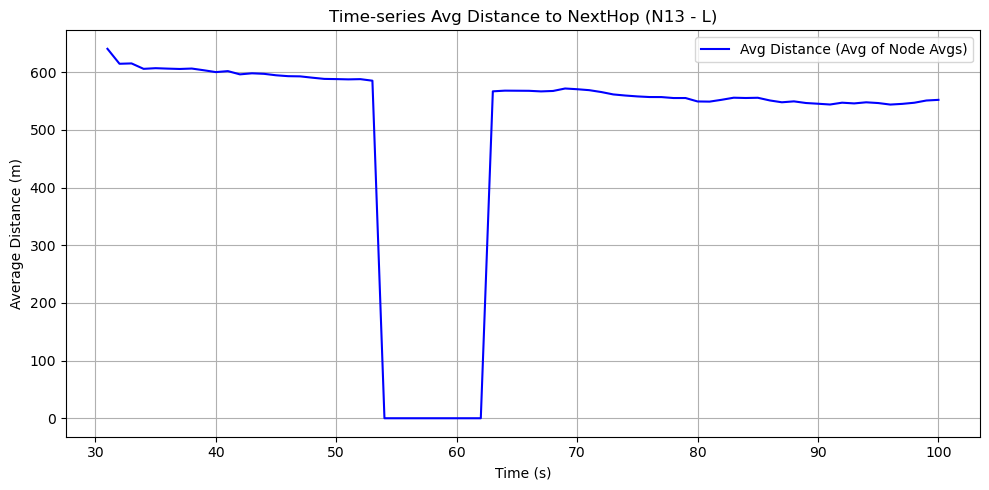

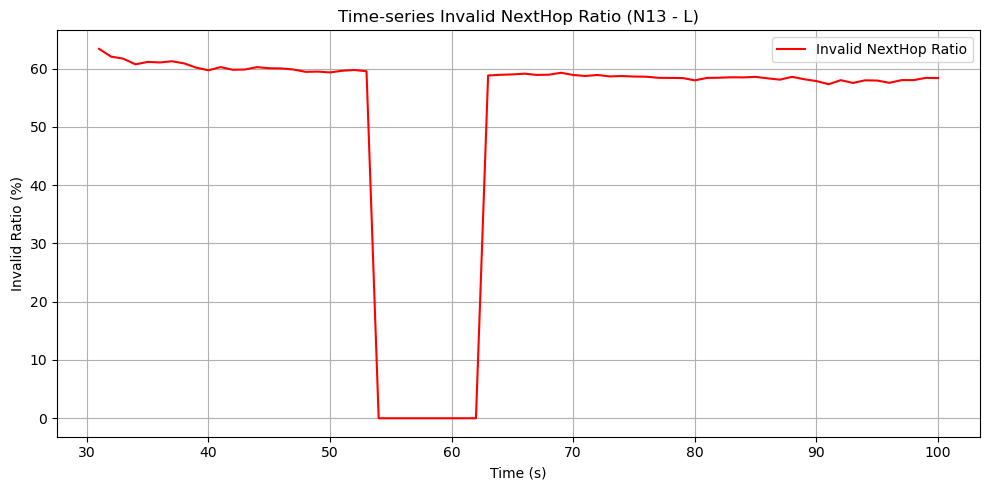


=== Method: P (N13 - Time-series Avg Distance & Invalid Ratio) ===
[P] Time=31s: AvgDist=632.82m, Invalid=1662 (63.78%), Total=2606
[P] Time=32s: AvgDist=617.20m, Invalid=2635 (62.07%), Total=4245
[P] Time=33s: AvgDist=614.54m, Invalid=2885 (61.75%), Total=4672
[P] Time=34s: AvgDist=607.70m, Invalid=3007 (61.48%), Total=4891
[P] Time=35s: AvgDist=609.71m, Invalid=3141 (61.56%), Total=5102
[P] Time=36s: AvgDist=609.17m, Invalid=3108 (61.19%), Total=5079
[P] Time=37s: AvgDist=606.48m, Invalid=3103 (61.12%), Total=5077
[P] Time=38s: AvgDist=604.54m, Invalid=3125 (60.81%), Total=5139
[P] Time=39s: AvgDist=601.47m, Invalid=3167 (60.06%), Total=5273
[P] Time=40s: AvgDist=598.03m, Invalid=3225 (60.37%), Total=5342
[P] Time=41s: AvgDist=601.24m, Invalid=3243 (60.83%), Total=5331
[P] Time=42s: AvgDist=600.03m, Invalid=3451 (60.29%), Total=5724
[P] Time=43s: AvgDist=597.97m, Invalid=3912 (60.10%), Total=6509
[P] Time=44s: AvgDist=597.11m, Invalid=3782 (59.89%), Total=6315
[P] Time=45s: AvgDist=

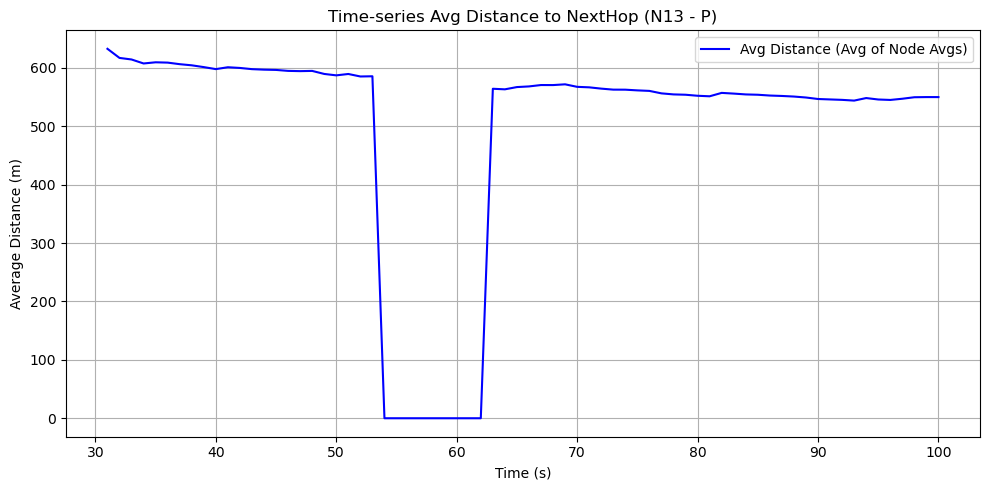

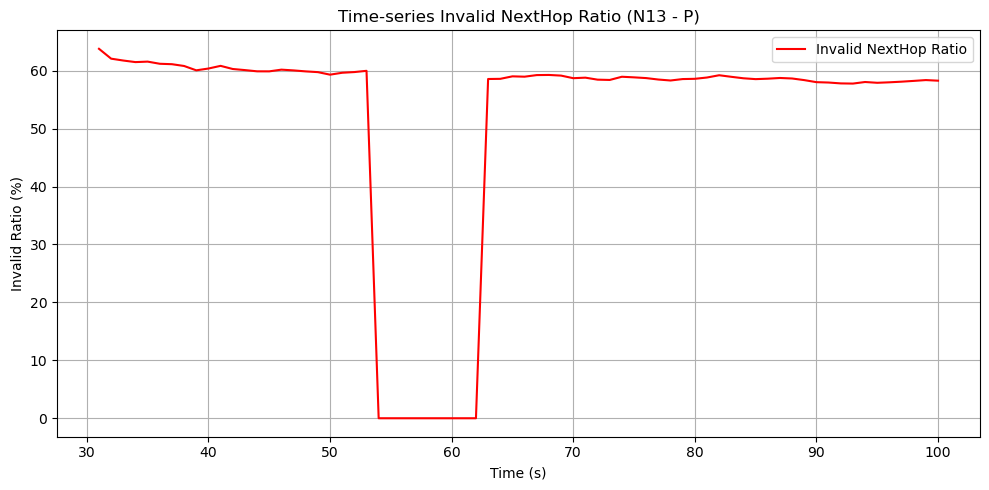

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

max_tx_dist = 500.0
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
node = "N13"
methods = ["L", "P"]

position_log_path = "./vehicle_position_log.csv"
if not os.path.exists(position_log_path):
    print(f"Missing vehicle position log: {position_log_path}")
    exit(1)
df_pos_all = pd.read_csv(position_log_path)

def parse_node_id(node_str):
    if isinstance(node_str, str) and "[" in node_str and "]" in node_str:
        return int(node_str.split("[")[1].split("]")[0])
    else:
        return None

for method in methods:
    print(f"\n=== Method: {method} (N13 - Time-series Avg Distance & Invalid Ratio) ===")

    avg_distances, invalid_ratios, times_for_plot = [], [], []
    route_log_path = os.path.join(base_path, method, density, speed, node, "routing_table_log.csv")
    if not os.path.exists(route_log_path):
        print(f"Missing routing log: {route_log_path}")
        continue

    df_route_all = pd.read_csv(route_log_path)
    time_list = sorted(df_route_all['Time'].unique())

    for target_time in time_list:
        df_pos = df_pos_all[df_pos_all["Time"] == target_time]
        if df_pos.empty:
            avg_distances.append(0)
            invalid_ratios.append(0)
            times_for_plot.append(target_time)
            continue

        df_route = df_route_all[df_route_all["Time"] == target_time]
        if df_route.empty:
            avg_distances.append(0)
            invalid_ratios.append(0)
            times_for_plot.append(target_time)
            continue

        node_avg_dists = []
        invalid, total = 0, 0

        for node_name in df_route['Node'].unique():
            node_id = parse_node_id(node_name)
            if node_id is None:
                continue

            node_pos = df_pos[df_pos["Node"] == node_id]
            if node_pos.empty:
                continue
            node_x, node_y = node_pos.iloc[0][["X", "Y"]]

            df_node_routes = df_route[df_route['Node'] == node_name]
            if df_node_routes.empty:
                continue

            distances = []

            for _, row in df_node_routes.iterrows():
                next_id = parse_node_id(row["NextHop"])
                if next_id is None:
                    continue

                next_pos = df_pos[df_pos["Node"] == next_id]
                if next_pos.empty:
                    continue

                next_x, next_y = next_pos.iloc[0][["X", "Y"]]
                dist = sqrt((node_x - next_x) ** 2 + (node_y - next_y) ** 2)
                distances.append(dist)

                total += 1
                if dist > max_tx_dist:
                    invalid += 1

            if distances:
                node_avg_dists.append(sum(distances) / len(distances))

        if node_avg_dists:
            overall_avg_dist = sum(node_avg_dists) / len(node_avg_dists)
            avg_distances.append(overall_avg_dist)
        else:
            avg_distances.append(0)

        if total > 0:
            invalid_ratio = (invalid / total) * 100.0
        else:
            invalid_ratio = 0.0
        invalid_ratios.append(invalid_ratio)
        times_for_plot.append(target_time)

        print(f"[{method}] Time={target_time}s: AvgDist={avg_distances[-1]:.2f}m, Invalid={invalid} ({invalid_ratio:.2f}%), Total={total}")

    plt.figure(figsize=(10, 5))
    plt.plot(times_for_plot, avg_distances, 'b-', label='Avg Distance (Avg of Node Avgs)')
    plt.xlabel("Time (s)")
    plt.ylabel("Average Distance (m)")
    plt.title(f"Time-series Avg Distance to NextHop (N13 - {method})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(times_for_plot, invalid_ratios, 'r-', label='Invalid NextHop Ratio')
    plt.xlabel("Time (s)")
    plt.ylabel("Invalid Ratio (%)")
    plt.title(f"Time-series Invalid NextHop Ratio (N13 - {method})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


[INFO] Routing Log Path: C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09/L/D400/S30/N13/routing_table_log.csv
[INFO] Position Log Path: vehicle_position_log.csv
[INFO] 분석 결과가 N13_next_hop_diff.csv로 저장되었습니다.


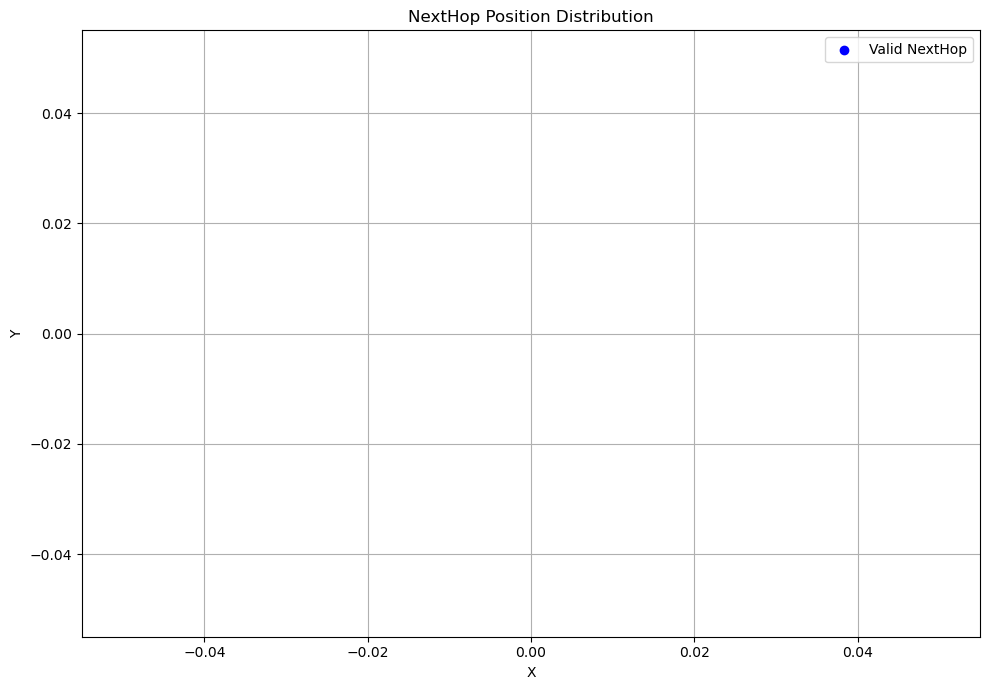

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

routing_log_path = r"C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_07_01_AppSci_AODV_V09/L/D400/S30/N13/routing_table_log.csv"
position_log_path = "vehicle_position_log.csv"

print(f"[INFO] Routing Log Path: {routing_log_path}")
print(f"[INFO] Position Log Path: {position_log_path}")

if not os.path.exists(routing_log_path):
    raise FileNotFoundError(f"[ERROR] routing_table_log.csv 파일이 존재하지 않습니다: {routing_log_path}")
if not os.path.exists(position_log_path):
    raise FileNotFoundError(f"[ERROR] vehicle_position_log.csv 파일이 존재하지 않습니다: {position_log_path}")

df_rt = pd.read_csv(routing_log_path)
df_pos = pd.read_csv(position_log_path)

results = []

for idx, row in df_rt.iterrows():
    time = int(row['Time'])
    node = str(row['Node'])
    nexthop = str(row['NextHop'])

    pos_next = df_pos[(df_pos['Time'] == time) & (df_pos['Node'] == nexthop)]
    if pos_next.empty:
        results.append({
            'Time': time, 'Node': node, 'NextHop': nexthop,
            'NextHop_X': None, 'NextHop_Y': None, 'Valid': False
        })
        continue

    mean_x = pos_next['X'].mean()
    mean_y = pos_next['Y'].mean()

    results.append({
        'Time': time, 'Node': node, 'NextHop': nexthop,
        'NextHop_X': mean_x, 'NextHop_Y': mean_y, 'Valid': True
    })

df_result = pd.DataFrame(results)
df_result.to_csv("N13_next_hop_diff.csv", index=False, encoding='utf-8-sig')
print("[INFO] 분석 결과가 N13_next_hop_diff.csv로 저장되었습니다.")

df_valid = df_result[df_result['Valid'] == True]

plt.figure(figsize=(10, 7))
plt.scatter(df_valid['NextHop_X'], df_valid['NextHop_Y'], c='blue', label='Valid NextHop')
plt.title("NextHop Position Distribution")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



=== Method: L (N0 - Time-series Invalid Ratio) ===
[L] Time=31s : Total=2428, Invalid=1970, Invalid Ratio=81.14%, node[0]=(932.92, 1231.07), avg NextHop=(737.44, 619.26)
[L] Time=32s : Total=4944, Invalid=3925, Invalid Ratio=79.39%, node[0]=(925.67, 1234.38), avg NextHop=(752.41, 639.47)
[L] Time=33s : Total=5411, Invalid=4320, Invalid Ratio=79.84%, node[0]=(919.22, 1233.17), avg NextHop=(750.83, 636.77)
[L] Time=34s : Total=6193, Invalid=4817, Invalid Ratio=77.78%, node[0]=(915.86, 1226.26), avg NextHop=(752.22, 640.98)
[L] Time=35s : Total=6390, Invalid=4929, Invalid Ratio=77.14%, node[0]=(912.62, 1218.95), avg NextHop=(754.51, 637.36)
[L] Time=36s : Total=6535, Invalid=5031, Invalid Ratio=76.99%, node[0]=(909.38, 1211.63), avg NextHop=(755.88, 639.23)
[L] Time=37s : Total=5681, Invalid=4325, Invalid Ratio=76.13%, node[0]=(906.14, 1204.32), avg NextHop=(761.06, 645.52)
[L] Time=38s : Total=5985, Invalid=4542, Invalid Ratio=75.89%, node[0]=(902.90, 1197.00), avg NextHop=(753.76, 639.

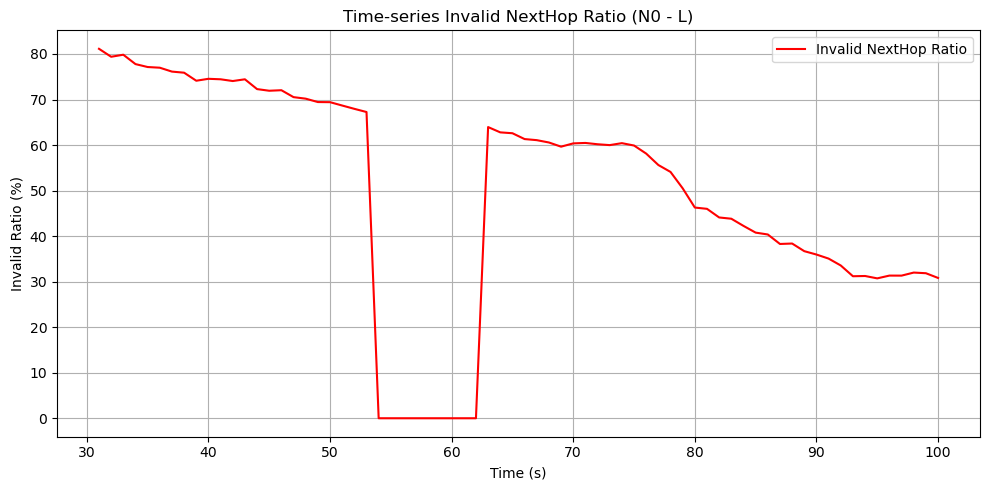


=== Method: P (N0 - Time-series Invalid Ratio) ===
[P] Time=31s : Total=2680, Invalid=2180, Invalid Ratio=81.34%, node[0]=(932.92, 1231.07), avg NextHop=(753.00, 621.21)
[P] Time=32s : Total=4366, Invalid=3448, Invalid Ratio=78.97%, node[0]=(925.67, 1234.38), avg NextHop=(763.11, 644.22)


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

max_tx_dist = 500.0
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/log/2025_06_17_AppSci_AODV_V07"
density = "D400"
speed = "S30"
node = "N13"
methods = ["L", "P"]

position_log_path = "./vehicle_position_log.csv"
if not os.path.exists(position_log_path):
    print(f"Missing vehicle position log: {position_log_path}")
    exit(1)
df_pos_all = pd.read_csv(position_log_path)

def parse_node_id(node_str):
    if isinstance(node_str, str) and "[" in node_str and "]" in node_str:
        return int(node_str.split("[")[1].split("]")[0])
    else:
        return None

for method in methods:
    print(f"\n=== Method: {method} (N0 - Time-series Invalid Ratio) ===")

    invalid_ratios, times_for_plot = [], []
    route_log_path = os.path.join(base_path, method, density, speed, node, "routing_table_log.csv")
    if not os.path.exists(route_log_path):
        print(f"Missing routing log: {route_log_path}")
        continue

    df_route_all = pd.read_csv(route_log_path)
    time_list = list(range(31, 101))

    for target_time in time_list:
        df_pos = df_pos_all[df_pos_all["Time"] == target_time]
        if df_pos.empty:
            invalid_ratios.append(0)
            times_for_plot.append(target_time)
            print(f"[{method}] Time={target_time}s : No position data → Invalid Ratio=0%")
            continue

        node_pos = df_pos[df_pos["Node"] == 0]
        if node_pos.empty:
            invalid_ratios.append(0)
            times_for_plot.append(target_time)
            print(f"[{method}] Time={target_time}s : No node[0] position → Invalid Ratio=0%")
            continue

        df_route = df_route_all[df_route_all["Time"] == target_time]
        if df_route.empty:
            invalid_ratios.append(0)
            times_for_plot.append(target_time)
            print(f"[{method}] Time={target_time}s : No routing data → Invalid Ratio=0%")
            continue

        total, invalid = 0, 0
        next_positions = []

        for _, row in df_route.iterrows():
            next_id = parse_node_id(row["NextHop"])
            if next_id is None:
                continue

            next_pos = df_pos[df_pos["Node"] == next_id]
            if next_pos.empty:
                continue

            node_x, node_y = node_pos.iloc[0][["X", "Y"]]
            next_x, next_y = next_pos.iloc[0][["X", "Y"]]
            dist = ((node_x - next_x)**2 + (node_y - next_y)**2)**0.5

            total += 1
            if dist > max_tx_dist:
                invalid += 1

            next_positions.append((next_x, next_y))

        if total > 0:
            invalid_ratio = (invalid / total) * 100.0
        else:
            invalid_ratio = 0.0

        invalid_ratios.append(invalid_ratio)
        times_for_plot.append(target_time)

        node_x, node_y = node_pos.iloc[0][["X", "Y"]]
        if next_positions:
            avg_next_x = sum(x for x, y in next_positions) / len(next_positions)
            avg_next_y = sum(y for x, y in next_positions) / len(next_positions)
            print(f"[{method}] Time={target_time}s : Total={total}, Invalid={invalid}, Invalid Ratio={invalid_ratio:.2f}%, node[0]=({node_x:.2f}, {node_y:.2f}), avg NextHop=({avg_next_x:.2f}, {avg_next_y:.2f})")
        else:
            print(f"[{method}] Time={target_time}s : Total={total}, Invalid={invalid}, Invalid Ratio={invalid_ratio:.2f}%, node[0]=({node_x:.2f}, {node_y:.2f}), avg NextHop=NA")

    plt.figure(figsize=(10, 5))
    plt.plot(times_for_plot, invalid_ratios, 'r-', label='Invalid NextHop Ratio')
    plt.xlabel("Time (s)")
    plt.ylabel("Invalid Ratio (%)")
    plt.title(f"Time-series Invalid NextHop Ratio (N0 - {method})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
